# IBM Applied Data Science Capstone Project - The Battle of Neighborhoods (Part 2)

## IBM Data Science Professional Specialization - Coursera


**This notebook is for the capstone project for the 9-courses specialization in Data Science Specialization of IBM provided on Coursera.**  
**This project will try to solve a problem or question by applying data science methods on the location data gotten from Zillo, LA restaurants and market inspection**



**There are three set of csv files available: 6 real estate datasets based on zipcode from zillow, one for LA food inspection records, and one for restaurant violation record. As for the GeoJason data, there's a good one provided by LA times(http://boundaries.latimes.com/set/zip-code-tabulation-areas-2012/ )**

These are the following steps: 
1. Clean up data types
2. Create new features
3. Transform the real estate and violation records and merge with inspection records
4. Find appropriate GeoJSON
5. Visualize some data

@Yuhung Chang Jokhai | LinkedIn: https://www.linkedin.com/in/dryuhungchang/ 


### Loading Libraries 

In [1]:
import pandas as pd
import re
from datetime import datetime
from dateutil.parser import parse
import missingno as msno
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import json

### LA Real Estate Market (Zillow)

Zillow provides real estate information. However, Zillow API does not allow users to download information based on zip code or city. Users can download detailed saling and listing records per address from Zillow API. Therefore, here the data applied in this case is **"Home Values"** data from https://www.zillow.com/research/data/.

**Here's the description of the chosen datasets:**  
Zillow Home Value Index (ZHVI): A smoothed, seasonally adjusted measure of the median estimated home value across a given region and housing type. It is a dollar-denominated alternative to repeat-sales indices. Zillow also publishes home value and other housing data for local markets, as well as a more detailed methodology and a comparison of ZHVI to the S&P CoreLogic Case-Shiller Home Price Indices.

Here, the data were selected based on Zip Code and include properties below:
1. 1-Bedroom
2. 2-Bedroom
3. 3-Bedroom
4. 4-Bedroom
5. 5-Bedroom or More
6. Single Family House


In [2]:
data1 = pd.read_csv(r'1bedroom.csv')  #Zip_Zhvi_1bedroom 
#data1.dtypes

In [3]:
data2 = pd.read_csv(r'2bedroom.csv', encoding = "ISO-8859-1", engine='python')
#data2.head() 

In [4]:
data3 = pd.read_csv(r'3bedroom.csv', encoding = "ISO-8859-1", engine='python')
#data3.head() 

In [5]:
data4 = pd.read_csv(r'4bedroom.csv', encoding = "ISO-8859-1", engine='python')
#data4.head() 

In [6]:
data5 = pd.read_csv(r'5BedroomOrMore.csv', encoding = "utf-8", engine='python')
#data5.head() 

In [7]:
data6 = pd.read_csv(r'SingleFamilyResidence.csv', encoding = "ISO-8859-1", engine='python')
data6.head() 

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07
0,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1,337200.0,338200.0,339000.0,...,1050700,1049700,1050800,1055800,1061200,1070000,1083000,1086000,1072000,1056500
1,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,2,210400.0,212200.0,212200.0,...,336700,335900,336000,335600,334200,333400,333500,333500,331800,330100
2,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,3,502900.0,504900.0,506300.0,...,1319300,1320800,1325400,1331900,1338800,1345000,1351100,1349700,1337100,1323500
3,91940,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,95400.0,95600.0,95800.0,...,179300,180200,181000,182100,183400,183100,182000,181800,183300,184300
4,93144,79936,El Paso,TX,El Paso,El Paso County,5,77300.0,77300.0,77300.0,...,126400,126900,127600,128200,128600,128900,128700,128500,129000,129800


### Focus on LA "Metro" 

In [8]:
DATA1 = data1[data1['Metro'].str.contains('Los Angeles', na=False)]
DATA2 = data2[data2['Metro'].str.contains('Los Angeles', na=False)]
DATA3 = data3[data3['Metro'].str.contains('Los Angeles', na=False)]
DATA4 = data4[data4['Metro'].str.contains('Los Angeles', na=False)]
DATA5 = data5[data5['Metro'].str.contains('Los Angeles', na=False)]
DATA6 = data6[data6['Metro'].str.contains('Los Angeles', na=False)]

DATA1.head(3)
#DATA1.shape

#DATA1.shape
#Bed1 = DATA1[['RegionID','RegionName','CountyName','SizeRank','2015-07']]
#Bed1.rename(columns={Bed1.columns[-1]: "OneBed" }, inplace = True)
#Bed1.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07
2,96027,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,3,83700.0,83200.0,82800.0,...,584200,588300,585800,584000,584500,586800,588800,591900,593300,592900
17,96025,90044,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,18,NaN,NaN,NaN,...,358000,358600,360300,363700,364900,365500,370000,375400,376200,374100
18,96239,90805,Long Beach,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,19,73100.0,73100.0,73000.0,...,330300,334400,334700,333400,331700,331300,333700,336500,339100,340300


In [9]:
DATA1.shape

(196, 287)

### Comparing different years

#### Getting 2015 real estate average price for different size of properties

In [11]:
col = DATA1.loc[:, "2015-01":"2015-12"]
Bed1_2015 = DATA1[['RegionID','RegionName','CountyName']]
#del House2015
Bed1_2015.loc[:,'1Bed'] = pd.Series(data=col.mean(axis=1)).astype(float)
#Bed2_2015.head()
#Bed2_2015.shape

In [12]:
col = pd.DataFrame( data = DATA2.loc[: , "2015-01":"2015-12"])
Bed2_2015 = DATA2[['RegionID','RegionName','CountyName']]
#del House2015
Bed2_2015.loc[:,'2Bed'] = pd.Series(data=col.mean(axis=1)).astype(float)
#Bed2_2015.head()
#Bed2_2015.shape

In [13]:
col = DATA3.loc[: , "2015-01":"2015-12"] 
Bed3_2015 = DATA3[['RegionID','RegionName','CountyName']]
#del House2015
Bed3_2015.loc[:,'3Bed'] = pd.Series(data=col.mean(axis=1)).astype(float)
#Bed3_2015.shape

In [14]:
col = DATA4.loc[: , "2015-01":"2015-12"] 
Bed4_2015 = DATA4[['RegionID','RegionName','CountyName']]
#del House2015
Bed4_2015.loc[:,'4Bed'] = pd.Series(data=col.mean(axis=1)).astype(float)
#Bed4_2015.head()
#Bed4_2015.shape

In [15]:
col = DATA5.loc[: , "2015-01":"2015-12"] 
Bed5_2015 = DATA5[['RegionID','RegionName','CountyName']]
#del House2015
Bed5_2015.loc[:,'5Bed or More'] = pd.Series(data=col.mean(axis=1)).astype(float)
#Bed5_2015.head()
#Bed5_2015.shape

In [16]:
col = DATA6.loc[: , "2015-01":"2015-12"] 
Bed6_2015 = DATA6[['RegionID','RegionName','CountyName']]
#del House2015
Bed6_2015.loc[:,'single family house'] = pd.Series(data=col.mean(axis=1)).astype(float)
#Bed6_2015.head()
#Bed6_2015.shape

In [17]:
#result = pd.merge(Bed1_2015,Bed2_2015, on='RegionID')
#del Price2015

Price2015 = pd.merge(Bed1_2015,Bed2_2015,  how='outer', 
                  left_on=['RegionID','RegionName','CountyName'], right_on = ['RegionID','RegionName','CountyName'])

Price2015 = pd.merge(Price2015,Bed3_2015,  how='outer', 
                  left_on=['RegionID','RegionName','CountyName'], right_on = ['RegionID','RegionName','CountyName'])

Price2015 = pd.merge(Price2015,Bed4_2015,  how='outer', 
                  left_on=['RegionID','RegionName','CountyName'], right_on = ['RegionID','RegionName','CountyName'])

Price2015 = pd.merge(Price2015,Bed5_2015,  how='outer', 
                  left_on=['RegionID','RegionName','CountyName'], right_on = ['RegionID','RegionName','CountyName'])

Price2015 = pd.merge(Price2015,Bed6_2015,  how='outer', 
                  left_on=['RegionID','RegionName','CountyName'], right_on = ['RegionID','RegionName','CountyName'])


#pdList = [Bed1_2015,Bed2_2015,Bed3_2015,Bed4_2015,Bed5_2015,Bed6_2015] 
#result = pd.concat(pdList, axis=1, sort=False)
Price2015.head(3)

,RegionID,RegionName,CountyName,1Bed,2Bed,3Bed,4Bed,5Bed or More,single family house
0,96027,90046,Los Angeles County,444766.666667,871650.000000,1.505192e+06,2.073117e+06,2.536367e+06,1.524542e+06
1,96025,90044,Los Angeles County,236108.333333,282158.333333,3.213167e+05,3.476417e+05,3.876083e+05,3.008167e+05
2,96239,90805,Los Angeles County,257275.000000,334508.333333,3.687083e+05,4.154667e+05,4.641583e+05,3.581250e+05


In [18]:
Price2015.shape

(352, 9)

#### Go through the same process for real estate price in 2016 and 2018

#### ** 2016 Price table

In [19]:
col = DATA1.loc[: , "2016-01":"2016-12"] 
Bed1_2016 = DATA1[['RegionID','RegionName','CountyName']] 
Bed1_2016.loc[:,'1Bed'] = pd.Series(data=col.mean(axis=1)).astype(float)

col = DATA2.loc[: , "2016-01":"2016-12"] 
Bed2_2016 = DATA2[['RegionID','RegionName','CountyName']] 
Bed2_2016.loc[:,'2Bed'] = pd.Series(data=col.mean(axis=1)).astype(float)

col = DATA3.loc[: , "2016-01":"2016-12"] 
Bed3_2016 = DATA3[['RegionID','RegionName','CountyName']] 
Bed3_2016.loc[:,'3Bed'] = pd.Series(data=col.mean(axis=1)).astype(float)

col = DATA4.loc[: , "2016-01":"2016-12"] 
Bed4_2016 = DATA4[['RegionID','RegionName','CountyName']] 
Bed4_2016.loc[:,'4Bed'] = pd.Series(data=col.mean(axis=1)).astype(float)

col = DATA5.loc[: , "2016-01":"2016-12"] 
Bed5_2016 = DATA5[['RegionID','RegionName','CountyName']] 
Bed5_2016.loc[:,'5Bed or More'] = pd.Series(data=col.mean(axis=1)).astype(float)

col = DATA6.loc[: , "2016-01":"2016-12"] 
Bed6_2016 = DATA6[['RegionID','RegionName','CountyName']] 
Bed6_2016.loc[:,'single family house'] = pd.Series(data=col.mean(axis=1)).astype(float)

In [20]:
Price2016 = pd.merge(Bed1_2016,Bed2_2016,  how='outer', 
                  left_on=['RegionID','RegionName','CountyName'], right_on = ['RegionID','RegionName','CountyName'])

Price2016 = pd.merge(Price2016,Bed3_2016,  how='outer', 
                  left_on=['RegionID','RegionName','CountyName'], right_on = ['RegionID','RegionName','CountyName'])

Price2016 = pd.merge(Price2016,Bed4_2016,  how='outer', 
                  left_on=['RegionID','RegionName','CountyName'], right_on = ['RegionID','RegionName','CountyName'])

Price2016 = pd.merge(Price2016,Bed5_2016,  how='outer', 
                  left_on=['RegionID','RegionName','CountyName'], right_on = ['RegionID','RegionName','CountyName'])

Price2016 = pd.merge(Price2016,Bed6_2016,  how='outer', 
                  left_on=['RegionID','RegionName','CountyName'], right_on = ['RegionID','RegionName','CountyName'])


#pdList = [Bed1_2016,Bed2_2016,Bed3_2016,Bed4_2016,Bed5_2016,Bed6_2016] 
#Price2016 = pd.merge(pdList, on=['RegionID','RegionName','CountyName'] )
Price2016.head(10)

,RegionID,RegionName,CountyName,1Bed,2Bed,3Bed,4Bed,5Bed or More,single family house
0,96027,90046,Los Angeles County,469258.333333,939133.333333,1.655133e+06,2.283242e+06,2.789475e+06,1.681958e+06
1,96025,90044,Los Angeles County,267000.000000,312916.666667,3.587500e+05,3.862667e+05,4.147333e+05,3.419250e+05
2,96239,90805,Los Angeles County,273725.000000,364900.000000,4.038833e+05,4.510333e+05,5.078583e+05,3.920500e+05
3,96193,90650,Los Angeles County,235250.000000,369308.333333,4.213583e+05,4.515167e+05,4.888000e+05,4.210667e+05
4,96990,92683,Orange County,450575.000000,424875.000000,5.455833e+05,6.417417e+05,6.949250e+05,5.713167e+05
5,96007,90026,Los Angeles County,636050.000000,752475.000000,8.187417e+05,9.199667e+05,9.341583e+05,7.963917e+05
6,96047,90066,Los Angeles County,416933.333333,917700.000000,1.244908e+06,1.482625e+06,1.764483e+06,1.253558e+06
7,96987,92677,Orange County,316591.666667,463675.000000,7.413000e+05,9.450083e+05,1.234100e+06,8.764167e+05
8,97023,92804,Orange County,249258.333333,335716.666667,5.020250e+05,5.285500e+05,6.169250e+05,5.112833e+05
9,96125,90280,Los Angeles County,294158.333333,348575.000000,3.891333e+05,4.190083e+05,4.492167e+05,3.758667e+05


#### ** 2017 Price table

In [21]:
col = DATA1.loc[: , "2017-01":"2017-12"] 
Bed1_2017 = DATA1[['RegionID','RegionName','CountyName']] 
Bed1_2017.loc[:,'1Bed'] = pd.Series(data=col.mean(axis=1)).astype(float)

col = DATA2.loc[: , "2017-01":"2017-12"] 
Bed2_2017 = DATA2[['RegionID','RegionName','CountyName']] 
Bed2_2017.loc[:,'2Bed'] = pd.Series(data=col.mean(axis=1)).astype(float)

col = DATA3.loc[: , "2017-01":"2017-12"] 
Bed3_2017 = DATA3[['RegionID','RegionName','CountyName']] 
Bed3_2017.loc[:,'3Bed'] = pd.Series(data=col.mean(axis=1)).astype(float)

col = DATA4.loc[: , "2017-01":"2017-12"] 
Bed4_2017 = DATA4[['RegionID','RegionName','CountyName']] 
Bed4_2017.loc[:,'4Bed'] = pd.Series(data=col.mean(axis=1)).astype(float)

col = DATA5.loc[: , "2017-01":"2017-12"] 
Bed5_2017 = DATA5[['RegionID','RegionName','CountyName']] 
Bed5_2017.loc[:,'5Bed or More'] = pd.Series(data=col.mean(axis=1)).astype(float)

col = DATA6.loc[: , "2017-01":"2017-12"] 
Bed6_2017 = DATA6[['RegionID','RegionName','CountyName']] 
Bed6_2017.loc[:,'single family house'] = pd.Series(data=col.mean(axis=1)).astype(float)

Price2017 = pd.merge(Bed1_2017,Bed2_2017,  how='outer', 
                  left_on=['RegionID','RegionName','CountyName'], right_on = ['RegionID','RegionName','CountyName'])

Price2017 = pd.merge(Price2017,Bed3_2017,  how='outer', 
                  left_on=['RegionID','RegionName','CountyName'], right_on = ['RegionID','RegionName','CountyName'])

Price2017 = pd.merge(Price2017,Bed4_2017,  how='outer', 
                  left_on=['RegionID','RegionName','CountyName'], right_on = ['RegionID','RegionName','CountyName'])

Price2017 = pd.merge(Price2017,Bed5_2017,  how='outer', 
                  left_on=['RegionID','RegionName','CountyName'], right_on = ['RegionID','RegionName','CountyName'])

Price2017 = pd.merge(Price2017,Bed6_2017,  how='outer', 
                  left_on=['RegionID','RegionName','CountyName'], right_on = ['RegionID','RegionName','CountyName'])
 
Price2017.head()

,RegionID,RegionName,CountyName,1Bed,2Bed,3Bed,4Bed,5Bed or More,single family house
0,96027,90046,Los Angeles County,518783.333333,1.018400e+06,1.810125e+06,2.503433e+06,3.066808e+06,1.839975e+06
1,96025,90044,Los Angeles County,326875.000000,3.520500e+05,4.028083e+05,4.276750e+05,4.703417e+05,3.838917e+05
2,96239,90805,Los Angeles County,306133.333333,3.951083e+05,4.431000e+05,4.867167e+05,5.548250e+05,4.269500e+05
3,96193,90650,Los Angeles County,243608.333333,3.988250e+05,4.541917e+05,4.882333e+05,5.273833e+05,4.542250e+05
4,96990,92683,Orange County,468066.666667,4.499500e+05,5.874167e+05,6.697833e+05,7.273167e+05,6.194083e+05


#### ** 2018 Price table

In [22]:
col = DATA1.loc[: , "2018-01":"2018-12"]
#col*= float(10**-6)
Bed1_2018 = DATA1[['RegionID','RegionName','CountyName']] 
Bed1_2018.loc[:,'1Bed'] = pd.Series(data=col.mean(axis=1)).astype(float)

col = DATA2.loc[: , "2018-01":"2018-12"] 
Bed2_2018 = DATA2[['RegionID','RegionName','CountyName']] 
Bed2_2018.loc[:,'2Bed'] = pd.Series(data=col.mean(axis=1)).astype(float)

col = DATA3.loc[: , "2018-01":"2018-12"] 
Bed3_2018 = DATA3[['RegionID','RegionName','CountyName']] 
Bed3_2018.loc[:,'3Bed'] = pd.Series(data=col.mean(axis=1)).astype(float)

col = DATA4.loc[: , "2018-01":"2018-12"] 
Bed4_2018 = DATA4[['RegionID','RegionName','CountyName']] 
Bed4_2018.loc[:,'4Bed'] = pd.Series(data=col.mean(axis=1)).astype(float)

col = DATA5.loc[: , "2018-01":"2018-12"] 
Bed5_2018 = DATA5[['RegionID','RegionName','CountyName']] 
Bed5_2018.loc[:,'5Bed or More'] = pd.Series(data=col.mean(axis=1)).astype(float)

col = DATA6.loc[: , "2018-01":"2018-12"] 
Bed6_2018 = DATA6[['RegionID','RegionName','CountyName']] 
Bed6_2018.loc[:,'single family house'] = pd.Series(data=col.mean(axis=1)).astype(float) 

Price2018 = pd.merge(Bed1_2018,Bed2_2018,  how='outer', 
                  left_on=['RegionID','RegionName','CountyName'], right_on = ['RegionID','RegionName','CountyName'])

Price2018 = pd.merge(Price2018,Bed3_2018,  how='outer', 
                  left_on=['RegionID','RegionName','CountyName'], right_on = ['RegionID','RegionName','CountyName'])

Price2018 = pd.merge(Price2018,Bed4_2018,  how='outer', 
                  left_on=['RegionID','RegionName','CountyName'], right_on = ['RegionID','RegionName','CountyName'])

Price2018 = pd.merge(Price2018,Bed5_2018,  how='outer', 
                  left_on=['RegionID','RegionName','CountyName'], right_on = ['RegionID','RegionName','CountyName'])

Price2018 = pd.merge(Price2018,Bed6_2018,  how='outer', 
                  left_on=['RegionID','RegionName','CountyName'], right_on = ['RegionID','RegionName','CountyName'])
Price2018.head()

,RegionID,RegionName,CountyName,1Bed,2Bed,3Bed,4Bed,5Bed or More,single family house
0,96027,90046,Los Angeles County,562875.000000,1.084158e+06,1.899192e+06,2.634000e+06,3.228342e+06,1.922708e+06
1,96025,90044,Los Angeles County,356000.000000,3.930500e+05,4.374250e+05,4.713917e+05,5.253500e+05,4.206667e+05
2,96239,90805,Los Angeles County,320766.666667,4.263000e+05,4.747750e+05,5.208583e+05,5.942167e+05,4.583500e+05
3,96193,90650,Los Angeles County,274208.333333,4.296083e+05,4.789167e+05,5.205000e+05,5.610917e+05,4.795917e+05
4,96990,92683,Orange County,527275.000000,4.874583e+05,6.333583e+05,7.236750e+05,7.734500e+05,6.620667e+05


In [23]:
Df_2015 = Price2015.drop(columns=['RegionID'])
Df_2016 = Price2016.drop(columns=['RegionID'])
Df_2017 = Price2017.drop(columns=['RegionID'])
Df_2018 = Price2018.drop(columns=['RegionID'])

Df_2015 = Df_2015.drop(columns=['CountyName'])
Df_2016 = Df_2016.drop(columns=['CountyName'])
Df_2017 = Df_2017.drop(columns=['CountyName'])
Df_2018 = Df_2018.drop(columns=['CountyName'])

Df_2015.fillna(Df_2015.min(axis=1), inplace=True)
Df_2016.fillna(Df_2016.min(axis=1), inplace=True) 
Df_2017.fillna(Df_2017.min(axis=1), inplace=True) 
Df_2018.fillna(Df_2018.min(axis=1), inplace=True) 
#df2['data'].fillna(df2[['a', 'b']].min(axis=1), inplace=True)
#Df_2015.fillna(0, inplace=True)
#Df_2016.fillna(0, inplace=True)
#Df_2017.fillna(0, inplace=True)
#Df_2018.fillna(0, inplace=True)

Df_2015.iloc[:,1:8] *= (10**-6)
Df_2016.iloc[:,1:8] *= (10**-6)
Df_2017.iloc[:,1:8] *= (10**-6)
Df_2018.iloc[:,1:8] *= (10**-6)


Df_2015 = Df_2015.sort_values(by=['RegionName'])
Df_2016 = Df_2016.sort_values(by=['RegionName'])
Df_2017 = Df_2017.sort_values(by=['RegionName'])
Df_2018 = Df_2018.sort_values(by=['RegionName'])

Df_2015['RegionName'] = Df_2015['RegionName'].astype(str).astype(object) 
Df_2016['RegionName'] = Df_2016['RegionName'].astype(str).astype(object) 
Df_2017['RegionName'] = Df_2017['RegionName'].astype(str).astype(object) 
Df_2018['RegionName'] = Df_2018['RegionName'].astype(str).astype(object) 


#### Download GeoJson from LA Times:
http://boundaries.latimes.com/set/zip-code-tabulation-areas-2012/ 

In [24]:
# load GeoJSON
with open('la-zip-code-areas-2012.geojson', 'r') as jsonFile:
    data = json.load(jsonFile)
tmp = data

### Createing a function for LA map

In [204]:
import folium
def CreateMap(table, zips, mapped_feature, add_text = '',TITLE = ''):
    # reading of the updated GeoJSON file
    la_geo = r'updated-file.json'
    # initiating a Folium map with LA's longitude and latitude
    m = folium.Map(location = [34.0522, -118.2437], zoom_start = 10)
    # creating a Choropleth map
    m.choropleth(
        geo_data = la_geo,
        fill_opacity = 0.7,
        line_opacity = 0.2,
        data = table,
        # refers to which key within the GeoJSON to map the ZIP code to
        key_on = 'feature.properties.name',
        # first element contains location information, second element contains feature of interest
        columns = [zips, mapped_feature],
        fill_color = 'Spectral_r', ##'RdYlBu_r',
        #legend_name = (' ').join(mapped_feature.split('_')).title() + ' ' + add_text + ' Across LA'
        legend_name = add_text + ' Across LA'
    )
    folium.LayerControl().add_to(m)
    # save map with filename based on the feature of interest
    m.save(outfile = TITLE+ mapped_feature + '_map.html')
    #display(m)

In [205]:
CreateMap(Df_2015, 'RegionName', '1Bed', 'Average Price for 1 Bedroom properties','2015_')
CreateMap(Df_2015, 'RegionName', '2Bed', 'Average Price for 2 Bedrooms properties','2015_')
CreateMap(Df_2015, 'RegionName', '3Bed', 'Average Price for 3 Bedrooms properties','2015_')
CreateMap(Df_2015, 'RegionName', '4Bed', 'Average Price for 4 Bedrooms properties','2015_')
CreateMap(Df_2015, 'RegionName', '5Bed or More', 'Average Price for 5 or more Bedrooms properties','2015_')
CreateMap(Df_2015, 'RegionName', 'single family house', 'Average Price single family houses','2015_')

In [206]:
CreateMap(Df_2016, 'RegionName', '1Bed', 'Average Price for 1 Bedroom properties','2016_')
CreateMap(Df_2016, 'RegionName', '2Bed', 'Average Price for 2 Bedrooms properties','2016_')
CreateMap(Df_2016, 'RegionName', '3Bed', 'Average Price for 3 Bedrooms properties','2016_')
CreateMap(Df_2016, 'RegionName', '4Bed', 'Average Price for 4 Bedrooms properties','2016_')
CreateMap(Df_2016, 'RegionName', '5Bed or More', 'Average Price for 5 or more Bedrooms properties','2016_')
CreateMap(Df_2016, 'RegionName', 'single family house', 'Average Price single family houses','2016_')

In [207]:
CreateMap(Df_2017, 'RegionName', '1Bed', 'Average Price for 1 Bedroom properties','2017_')
CreateMap(Df_2017, 'RegionName', '2Bed', 'Average Price for 2 Bedrooms properties','2017_')
CreateMap(Df_2017, 'RegionName', '3Bed', 'Average Price for 3 Bedrooms properties','2017_')
CreateMap(Df_2017, 'RegionName', '4Bed', 'Average Price for 4 Bedrooms properties','2017_')
CreateMap(Df_2017, 'RegionName', '5Bed or More', 'Average Price for 5 or more Bedrooms properties','2017_')
CreateMap(Df_2017, 'RegionName', 'single family house', 'Average Price single family houses','2017_')

In [208]:
CreateMap(Df_2018, 'RegionName', '1Bed', 'Average Price for 1 Bedroom properties','2018_')
CreateMap(Df_2018, 'RegionName', '2Bed', 'Average Price for 2 Bedrooms properties','2018_')
CreateMap(Df_2018, 'RegionName', '3Bed', 'Average Price for 3 Bedrooms properties','2018_')
CreateMap(Df_2018, 'RegionName', '4Bed', 'Average Price for 4 Bedrooms properties','2018_')
CreateMap(Df_2018, 'RegionName', '5Bed or More', 'Average Price for 5 or more Bedrooms properties','2018_')
CreateMap(Df_2018, 'RegionName', 'single family house', 'Average Price single family houses','2018_')

### Comparing different property size

In [32]:
bed1_df= pd.merge(Df_2015[Df_2015.columns[0:2]],Df_2016[Df_2016.columns[0:2]], on = 'RegionName', how = 'outer')
bed1_df= pd.merge(bed1_df,Df_2017[Df_2017.columns[0:2]], on = 'RegionName', how = 'outer')
bed1_df= pd.merge(bed1_df,Df_2018[Df_2018.columns[0:2]], on = 'RegionName', how = 'outer')
bed1_df['1Bed_Avg'] = bed1_df[bed1_df.columns[1:5]].mean(axis=1)
bed1_df = bed1_df.iloc[:,[0,5]]
#bed1_df = bed1_df[bed1_df.columns[0,5]]
bed1_df.head()
#bed1_df.shape

,RegionName,1Bed_Avg
0,90001,0.241094
1,90002,0.252473
2,90003,0.270273
3,90004,0.585181
4,90005,NaN


In [33]:
bed2_df= pd.merge(Df_2015[['RegionName','2Bed']],Df_2016[['RegionName','2Bed']], on = 'RegionName', how = 'outer')
bed2_df= pd.merge(bed2_df,Df_2017[['RegionName','2Bed']], on = 'RegionName', how = 'outer')
bed2_df= pd.merge(bed2_df,Df_2018[['RegionName','2Bed']], on = 'RegionName', how = 'outer')
bed2_df['2Bed_Avg'] = bed2_df[bed2_df.columns[1:5]].mean(axis=1)
bed2_df = bed2_df.iloc[:,[0,5]]
#bed1_df = bed1_df[bed1_df.columns[0,5]]
#bed2_df.head()
#bed1_df.shape

In [34]:
bed3_df= pd.merge(Df_2015[['RegionName','3Bed']],Df_2016[['RegionName','3Bed']], on = 'RegionName', how = 'outer')
bed3_df= pd.merge(bed3_df,Df_2017[['RegionName','3Bed']], on = 'RegionName', how = 'outer')
bed3_df= pd.merge(bed3_df,Df_2018[['RegionName','3Bed']], on = 'RegionName', how = 'outer')
bed3_df['3Bed_Avg'] = bed3_df[bed3_df.columns[1:5]].mean(axis=1)
bed3_df = bed3_df.iloc[:,[0,5]]
#bed1_df = bed1_df[bed1_df.columns[0,5]]
#bed3_df.head()
#bed1_df.shape

In [35]:
bed4_df= pd.merge(Df_2015[['RegionName','4Bed']],Df_2016[['RegionName','4Bed']], on = 'RegionName', how = 'outer')
bed4_df= pd.merge(bed4_df,Df_2017[['RegionName','4Bed']], on = 'RegionName', how = 'outer')
bed4_df= pd.merge(bed4_df,Df_2018[['RegionName','4Bed']], on = 'RegionName', how = 'outer')
bed4_df['4Bed_Avg'] = bed4_df[bed4_df.columns[1:5]].mean(axis=1)
bed4_df = bed4_df.iloc[:,[0,5]]
#bed1_df = bed1_df[bed1_df.columns[0,5]]
#bed4_df.head()
#bed1_df.shape

In [36]:
bed5_df= pd.merge(Df_2015[['RegionName','5Bed or More']],Df_2016[['RegionName','5Bed or More']], on = 'RegionName', how = 'outer')
bed5_df= pd.merge(bed5_df,Df_2017[['RegionName','5Bed or More']], on = 'RegionName', how = 'outer')
bed5_df= pd.merge(bed5_df,Df_2018[['RegionName','5Bed or More']], on = 'RegionName', how = 'outer')
bed5_df['5Bed_Avg'] = bed5_df[bed5_df.columns[1:5]].mean(axis=1)
bed5_df = bed5_df.iloc[:,[0,5]]
#bed1_df = bed1_df[bed1_df.columns[0,5]]
#bed5_df.head()
#bed1_df.shape

In [37]:
bed6_df= pd.merge(Df_2015[['RegionName','single family house']],Df_2016[['RegionName','single family house']], on = 'RegionName', how = 'outer')
bed6_df= pd.merge(bed6_df,Df_2017[['RegionName','single family house']], on = 'RegionName', how = 'outer')
bed6_df= pd.merge(bed6_df,Df_2018[['RegionName','single family house']], on = 'RegionName', how = 'outer')
bed6_df['Single Family_Avg'] = bed6_df[bed6_df.columns[1:5]].mean(axis=1)
bed6_df = bed6_df.iloc[:,[0,5]]
#bed1_df = bed1_df[bed1_df.columns[0,5]]
#bed6_df.head()
#bed1_df.shape

In [38]:
bed1_df['RegionName'] = bed1_df['RegionName'].astype(str).astype(object) 
bed2_df['RegionName'] = bed2_df['RegionName'].astype(str).astype(object) 
bed3_df['RegionName'] = bed3_df['RegionName'].astype(str).astype(object) 
bed4_df['RegionName'] = bed4_df['RegionName'].astype(str).astype(object) 
bed5_df['RegionName'] = bed5_df['RegionName'].astype(str).astype(object) 
bed6_df['RegionName'] = bed6_df['RegionName'].astype(str).astype(object) 

In [210]:
CreateMap(bed1_df, 'RegionName', '1Bed_Avg', 'Average Price for 1 Bedroom properties','Average 1Bed') 
CreateMap(bed2_df, 'RegionName', '2Bed_Avg', 'Average Price for 1 Bedroom properties','Average 2Bed') 
CreateMap(bed3_df, 'RegionName', '3Bed_Avg', 'Average Price for 1 Bedroom properties','Average 3Bed') 
CreateMap(bed4_df, 'RegionName', '4Bed_Avg', 'Average Price for 1 Bedroom properties','Average 4Bed') 
CreateMap(bed5_df, 'RegionName', '5Bed_Avg', 'Average Price for 1 Bedroom properties','Average 5Bed or More') 
CreateMap(bed6_df, 'RegionName', 'Single Family_Avg', 'Average Price for 1 Bedroom properties','Average Single Family') 

### LA Restaurant Health Inspection

##### LOS ANGELES COUNTY RESTAURANT AND MARKET INSPECTIONS
https://data.lacounty.gov/Health/LOS-ANGELES-COUNTY-RESTAURANT-AND-MARKET-INSPECTIO/6ni6-h5kp

##### LOS ANGELES COUNTY RESTAURANT AND MARKET VIOLATIONS
https://data.lacounty.gov/Health/LOS-ANGELES-COUNTY-RESTAURANT-AND-MARKET-VIOLATION/8jyd-4pv9

We look at the LA county restaurant and market inspection dataset for this purpose.  

In [40]:
inspect_df = pd.read_csv('LA-inspections.csv')
inspect_df.head()

,serial_number,activity_date,facility_name,score,grade,service_code,service_description,employee_id,facility_address,facility_city,facility_id,facility_state,facility_zip,owner_id,owner_name,pe_description,program_element_pe,program_name,program_status,record_id
0,DAJ00E07B,2017-12-29T00:00:00,HABITAT COFFEE SHOP,95,A,1,ROUTINE INSPECTION,EE0000923,3708 N EAGLE ROCK BLVD,LOS ANGELES,FA0170465,CA,90065,OW0178123,GLASSELL COFFEE SHOP LLC,RESTAURANT (0-30) SEATS MODERATE RISK,1631,HABITAT COFFEE SHOP,ACTIVE,PR0160774
1,DAQOKRFZB,2017-12-29T00:00:00,REILLY'S,92,A,1,ROUTINE INSPECTION,EE0000633,100 WORLD WAY # 120,LOS ANGELES,FA0244690,CA,90045,OW0208441,"AREAS SKYVIEW LAX JV, LLC",RESTAURANT (0-30) SEATS MODERATE RISK,1631,REILLY'S,ACTIVE,PR0193026
2,DASJI4LUR,2017-12-29T00:00:00,STREET CHURROS,93,A,1,ROUTINE INSPECTION,EE0000835,6801 HOLLYWOOD BLVD # 253,LOS ANGELES,FA0224109,CA,90028,OW0228670,"STREETCHURROS, INC",RESTAURANT (0-30) SEATS LOW RISK,1630,STREET CHURROS,ACTIVE,PR0179282
3,DAWVA0CY3,2017-12-29T00:00:00,RIO GENTLEMANS CLUB,93,A,1,ROUTINE INSPECTION,EE0000958,13124 S FIGUEROA ST,LOS ANGELES,FA0046462,CA,90064,OW0011830,FIGUEROA GROUP INC,RESTAURANT (61-150) SEATS LOW RISK,1636,RIO GENTLEMANS CLUB,ACTIVE,PR0044776
4,DAKFCHD0L,2017-12-29T00:00:00,LE PAIN QUOTIDIEN,93,A,1,ROUTINE INSPECTION,EE0000629,13050 SAN VICENTE BLVD STE 114,LOS ANGELES,FA0034788,CA,90049,OW0028928,PQ SAN VICENTE INC.,RESTAURANT (61-150) SEATS HIGH RISK,1638,LE PAIN QUOTIDIEN,ACTIVE,PR0017456


In [41]:
violate_df = pd.read_csv('LA-violations.csv')
violate_df.head()

,serial_number,activity_date,facility_name,violation_code,violation_description,violation_status,points,grade,facility_address,facility_city,...,owner_name,pe_description,program_element_pe,program_name,program_status,record_id,score,service_code,service_description,row_id
0,DA08R0TCU,2018-03-30T00:00:00,KRUANG TEDD,F030,# 30. Food properly stored; food storage conta...,OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF030
1,DA08R0TCU,2018-03-30T00:00:00,KRUANG TEDD,F027,# 27. Food separated and protected,OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF027
2,DA08R0TCU,2018-03-30T00:00:00,KRUANG TEDD,F035,# 35. Equipment/Utensils - approved; installed...,OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF035
3,DA08R0TCU,2018-03-30T00:00:00,KRUANG TEDD,F033,# 33. Nonfood-contact surfaces clean and in go...,OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF033
4,DA08R0TCU,2018-03-30T00:00:00,KRUANG TEDD,F029,"# 29. Toxic substances properly identified, st...",OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF029


In [42]:
inspect_df.dtypes

serial_number          object
activity_date          object
facility_name          object
score                   int64
grade                  object
service_code            int64
service_description    object
employee_id            object
facility_address       object
facility_city          object
facility_id            object
facility_state         object
facility_zip           object
owner_id               object
owner_name             object
pe_description         object
program_element_pe      int64
program_name           object
program_status         object
record_id              object
dtype: object

In [43]:
def dateobj(str):
    return datetime.strptime(str, '%Y-%m-%dT%H:%M:%S')

In [44]:
inspect_df['activity_date'] = inspect_df['activity_date'].apply(dateobj)
violate_df['activity_date'] = violate_df['activity_date'].apply(dateobj)

In [45]:
inspect_df.head(3)

,serial_number,activity_date,facility_name,score,grade,service_code,service_description,employee_id,facility_address,facility_city,facility_id,facility_state,facility_zip,owner_id,owner_name,pe_description,program_element_pe,program_name,program_status,record_id
0,DAJ00E07B,2017-12-29,HABITAT COFFEE SHOP,95,A,1,ROUTINE INSPECTION,EE0000923,3708 N EAGLE ROCK BLVD,LOS ANGELES,FA0170465,CA,90065,OW0178123,GLASSELL COFFEE SHOP LLC,RESTAURANT (0-30) SEATS MODERATE RISK,1631,HABITAT COFFEE SHOP,ACTIVE,PR0160774
1,DAQOKRFZB,2017-12-29,REILLY'S,92,A,1,ROUTINE INSPECTION,EE0000633,100 WORLD WAY # 120,LOS ANGELES,FA0244690,CA,90045,OW0208441,"AREAS SKYVIEW LAX JV, LLC",RESTAURANT (0-30) SEATS MODERATE RISK,1631,REILLY'S,ACTIVE,PR0193026
2,DASJI4LUR,2017-12-29,STREET CHURROS,93,A,1,ROUTINE INSPECTION,EE0000835,6801 HOLLYWOOD BLVD # 253,LOS ANGELES,FA0224109,CA,90028,OW0228670,"STREETCHURROS, INC",RESTAURANT (0-30) SEATS LOW RISK,1630,STREET CHURROS,ACTIVE,PR0179282


In [46]:
inspect_df.shape

(58872, 20)

In [47]:
violate_df.head(3)

,serial_number,activity_date,facility_name,violation_code,violation_description,violation_status,points,grade,facility_address,facility_city,...,owner_name,pe_description,program_element_pe,program_name,program_status,record_id,score,service_code,service_description,row_id
0,DA08R0TCU,2018-03-30,KRUANG TEDD,F030,# 30. Food properly stored; food storage conta...,OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF030
1,DA08R0TCU,2018-03-30,KRUANG TEDD,F027,# 27. Food separated and protected,OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF027
2,DA08R0TCU,2018-03-30,KRUANG TEDD,F035,# 35. Equipment/Utensils - approved; installed...,OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF035


In [48]:
violate_df.dtypes

serial_number                    object
activity_date            datetime64[ns]
facility_name                    object
violation_code                   object
violation_description            object
violation_status                 object
points                            int64
grade                            object
facility_address                 object
facility_city                    object
facility_id                      object
facility_state                   object
facility_zip                     object
employee_id                      object
owner_id                         object
owner_name                       object
pe_description                   object
program_element_pe                int64
program_name                     object
program_status                   object
record_id                        object
score                             int64
service_code                      int64
service_description              object
row_id                           object


In [49]:
violate_df.shape

(272801, 25)

In [50]:
inspect_places = inspect_df['facility_name'].unique()
violate_places = violate_df['facility_name'].unique()

In [51]:
inspect_df['activity_date'].min()

Timestamp('2015-07-01 00:00:00')

In [52]:
inspect_df['activity_date'].max()

Timestamp('2018-03-30 00:00:00')

In [53]:
violate_df['activity_date'].min()

Timestamp('2015-10-01 00:00:00')

In [54]:
violate_df['activity_date'].max()

Timestamp('2018-03-30 00:00:00')

In [55]:
len(set(inspect_places) - set(violate_places))

301

In [56]:
len(inspect_places) - len(violate_places)


299

In [57]:
violate_df['violation_status'].value_counts()

OUT OF COMPLIANCE       272799
HOUSING NON-CRITICAL         1
VIOLATION                    1
Name: violation_status, dtype: int64

#### Violation outliers

A look at the violation codes yield codes that mostly begin with a 'F'. There seem to be a few starting with 'W' that only appear once or twice. When matched with the violation description, they were the only descriptions that did not have a violation number in front of them. Furthermore, some didn't even result in point deductions. As they only make up 17 entries out of the 272,801 violations, we can safely drop them.

In [58]:
violate_df['violation_code'].value_counts().nsmallest(20)

W051     1
W019     1
W027     1
W004     1
H102     1
W005     1
W021     1
W052     1
W032     1
W028     1
W034     1
W044     1
F056     2
W023     3
F002     6
F012    10
F017    10
F003    11
F051    12
F010    14
Name: violation_code, dtype: int64

In [59]:
violate_df[violate_df['violation_code'].isin(violate_df['violation_code'].value_counts().nsmallest(14).index)].head(3)

,serial_number,activity_date,facility_name,violation_code,violation_description,violation_status,points,grade,facility_address,facility_city,...,owner_name,pe_description,program_element_pe,program_name,program_status,record_id,score,service_code,service_description,row_id
18900,DAZTR8FK3,2018-01-23,SUKARNE,W019,Plumbing approved and maintained in good repair.,OUT OF COMPLIANCE,0,A,1500 E OLYMPIC BLVD # 1-37,LOS ANGELES,...,VIZ CATTLE CORPORATION,"FOOD MKT RETAIL (25-1,999 SF) MODERATE RISK",1611,SUKARNE,ACTIVE,PR0189140,100,1,ROUTINE INSPECTION,DAZTR8FK3W019
18901,DAZTR8FK3,2018-01-23,SUKARNE,W044,Garbage / Rubbish receptacles maintained clean...,OUT OF COMPLIANCE,0,A,1500 E OLYMPIC BLVD # 1-37,LOS ANGELES,...,VIZ CATTLE CORPORATION,"FOOD MKT RETAIL (25-1,999 SF) MODERATE RISK",1611,SUKARNE,ACTIVE,PR0189140,100,1,ROUTINE INSPECTION,DAZTR8FK3W044
18902,DAZTR8FK3,2018-01-23,SUKARNE,W023,Floor maintained clean,OUT OF COMPLIANCE,0,A,1500 E OLYMPIC BLVD # 1-37,LOS ANGELES,...,VIZ CATTLE CORPORATION,"FOOD MKT RETAIL (25-1,999 SF) MODERATE RISK",1611,SUKARNE,ACTIVE,PR0189140,100,1,ROUTINE INSPECTION,DAZTR8FK3W023


In [60]:
violate_df['violation_description'].value_counts().head(3)

# 44. Floors, walls and ceilings: properly built, maintained in good repair and clean    30289
# 33. Nonfood-contact surfaces clean and in good repair                                  28426
# 35. Equipment/Utensils - approved; installed; clean; good repair, capacity             23596
Name: violation_description, dtype: int64

In [61]:
violate_df = violate_df[~violate_df['violation_code'].isin(violate_df['violation_code'].value_counts()
                                                           .nsmallest(14).index)]
violate_df.shape

(272784, 25)

In [62]:
len(violate_df['violation_description'].unique())

53

In [63]:
len(violate_df['violation_code'].unique())

56

### Creating new features based on establishment description

When looking at the column 'pe_description', it seems to describe 3 different things: what type of establishment it is, how many people it can host, and the risk level.

To better represent the data, we write three helper functions with regex and string split to create new feature variables.

In [64]:
inspect_df['pe_description'].unique()

array(['RESTAURANT (0-30) SEATS MODERATE RISK',
       'RESTAURANT (0-30) SEATS LOW RISK',
       'RESTAURANT (61-150) SEATS LOW RISK',
       'RESTAURANT (61-150) SEATS HIGH RISK',
       'FOOD MKT RETAIL (25-1,999 SF) LOW RISK',
       'RESTAURANT (0-30) SEATS HIGH RISK',
       'FOOD MKT RETAIL (2,000+ SF) LOW RISK',
       'RESTAURANT (31-60) SEATS HIGH RISK',
       'FOOD MKT RETAIL (25-1,999 SF) MODERATE RISK',
       'RESTAURANT (151 + ) SEATS MODERATE RISK',
       'RESTAURANT (61-150) SEATS MODERATE RISK',
       'RESTAURANT (151 + ) SEATS HIGH RISK',
       'FOOD MKT RETAIL (25-1,999 SF) HIGH RISK',
       'RESTAURANT (31-60) SEATS MODERATE RISK',
       'FOOD MKT RETAIL (2,000+ SF) HIGH RISK',
       'FOOD MKT RETAIL (2,000+ SF) MODERATE RISK',
       'RESTAURANT (31-60) SEATS LOW RISK',
       'RESTAURANT (151 + ) SEATS LOW RISK'], dtype=object)

### Quick and dirty regex

A quick description of the two regex statements used here:

For extracting the type of establishment, we want to get everything before the first opening parentheses. The regex was thus in the form .+(?= \()
<br>.+ => This matches, returns any character, and keeps going. The use of '+' means it has to match at least once.
<br>(?= \() => This is a lookahead which indicates that the string ends with ' (' and that the open parentheses will not be returned. 

For extracting the size of the establishment, I used the regex (?<=\().+(?=\))
<br>(?<=\() => This is a lookbehind which indicates that the string starts with an open parentheses which will not be returned.
<br>.+ => Like above, returns any character and continues.
<br>(?=\)) => Like above, a lookahead that indicates the string ends with a close parentheses which will not be returned.

In [65]:
def find_est(str):
    est = re.compile('.+(?= \()')
    return est.search(str).group(0)
def find_size(str):
    size = re.compile('(?<=\().+(?=\))')
    return size.search(str).group(0)
def find_risk(str):
    return (' ').join(str.split(' ')[-2:])

In [66]:
teststr = 'FOOD MKT RETAIL (25-1,999 SF) LOW RISK'

In [67]:
print(find_est(teststr))
print(find_size(teststr))
print(find_risk(teststr))

FOOD MKT RETAIL
25-1,999 SF
LOW RISK


In [68]:
inspect_df['owner_name'].value_counts().nlargest(10)

RALPHS GROCERY COMPANY                          557
LEVY PREMIUM FOOD SERVICE LP                    468
LEVY PREMIUM FOODSERVICE LIMITED PARTNERSHIP    323
STARBUCKS COFFEE CORPORATION                    273
LEGENDS HOSPITALITY, LLC.                       234
THE VONS COMPANIES INC.                         234
FOOD 4 LESS, INC.                               232
HOST INTERNATIONAL INC                          211
WHOLE FOODS MARKET, INC.                        198
SOUTHERN CALIFORNIA PIZZA CO LLC                167
Name: owner_name, dtype: int64

In [69]:
inspect_df['est_type'] = inspect_df['pe_description'].apply(find_est)
inspect_df['seats'] = inspect_df['pe_description'].apply(find_size)
inspect_df['risk'] = inspect_df['pe_description'].apply(find_risk)
inspect_df.head(3)

,serial_number,activity_date,facility_name,score,grade,service_code,service_description,employee_id,facility_address,facility_city,...,owner_id,owner_name,pe_description,program_element_pe,program_name,program_status,record_id,est_type,seats,risk
0,DAJ00E07B,2017-12-29,HABITAT COFFEE SHOP,95,A,1,ROUTINE INSPECTION,EE0000923,3708 N EAGLE ROCK BLVD,LOS ANGELES,...,OW0178123,GLASSELL COFFEE SHOP LLC,RESTAURANT (0-30) SEATS MODERATE RISK,1631,HABITAT COFFEE SHOP,ACTIVE,PR0160774,RESTAURANT,0-30,MODERATE RISK
1,DAQOKRFZB,2017-12-29,REILLY'S,92,A,1,ROUTINE INSPECTION,EE0000633,100 WORLD WAY # 120,LOS ANGELES,...,OW0208441,"AREAS SKYVIEW LAX JV, LLC",RESTAURANT (0-30) SEATS MODERATE RISK,1631,REILLY'S,ACTIVE,PR0193026,RESTAURANT,0-30,MODERATE RISK
2,DASJI4LUR,2017-12-29,STREET CHURROS,93,A,1,ROUTINE INSPECTION,EE0000835,6801 HOLLYWOOD BLVD # 253,LOS ANGELES,...,OW0228670,"STREETCHURROS, INC",RESTAURANT (0-30) SEATS LOW RISK,1630,STREET CHURROS,ACTIVE,PR0179282,RESTAURANT,0-30,LOW RISK


In [115]:
#%matplotlib inline
#msno.matrix(inspect_df)

In [116]:
#%matplotlib inline
#msno.matrix(violate_df)

In [72]:
violate_df.head(3)

,serial_number,activity_date,facility_name,violation_code,violation_description,violation_status,points,grade,facility_address,facility_city,...,owner_name,pe_description,program_element_pe,program_name,program_status,record_id,score,service_code,service_description,row_id
0,DA08R0TCU,2018-03-30,KRUANG TEDD,F030,# 30. Food properly stored; food storage conta...,OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF030
1,DA08R0TCU,2018-03-30,KRUANG TEDD,F027,# 27. Food separated and protected,OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF027
2,DA08R0TCU,2018-03-30,KRUANG TEDD,F035,# 35. Equipment/Utensils - approved; installed...,OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF035


## Creating dataframe of all violation counts

Individual violations do not seem to tell us much about a particular location. Let's create a new dataframe from the violation dataframe that represents all the different violations and the total number of each violation each facility has.

We begin this by grouping the violation dataframe by the facility id and the violation code. We then aggregate by the count to find the total times each facility has violated a particular rule. 

In [74]:
vio_grouped = violate_df.groupby(['facility_id','violation_code'])
vio_counts = vio_grouped.agg({
    'violation_code': 'count'
})
vio_counts.head()

violation_code
facility_id violation_code                
FA0000968   F006                         1
            F029                         2
            F033                         3
            F035                         1
            F036                         3

We take this new dataframe and unstack it. We then transpose the resultant dataframe so that the violation codes are now the columns. We then reset the index so that a new facility_id column is created. Now we can merge the inspection dataframe with this dataframe so that each facility has a set of columns for the counts of every violation.

In [81]:
vio_matrix = vio_counts['violation_code'].unstack(0).T
vio_matrix.fillna(0, inplace=True)
vio_matrix.reset_index(inplace=True)
vio_matrix.head()

violation_code,facility_id,F001,F002,F003,F004,F005,F006,F007,F008,F009,...,F048,F049,F050,F051,F052,F053,F054,F055,F057,F058
0,FA0000968,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FA0000999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FA0001155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,FA0001320,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,FA0001404,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [82]:
inspect_vio_df = pd.merge(inspect_df, vio_matrix, on='facility_id', how='left')
inspect_vio_df.head()

,serial_number,activity_date,facility_name,score,grade,service_code,service_description,employee_id,facility_address,facility_city,...,F048,F049,F050,F051,F052,F053,F054,F055,F057,F058
0,DAJ00E07B,2017-12-29,HABITAT COFFEE SHOP,95,A,1,ROUTINE INSPECTION,EE0000923,3708 N EAGLE ROCK BLVD,LOS ANGELES,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DAQOKRFZB,2017-12-29,REILLY'S,92,A,1,ROUTINE INSPECTION,EE0000633,100 WORLD WAY # 120,LOS ANGELES,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,DASJI4LUR,2017-12-29,STREET CHURROS,93,A,1,ROUTINE INSPECTION,EE0000835,6801 HOLLYWOOD BLVD # 253,LOS ANGELES,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,DAWVA0CY3,2017-12-29,RIO GENTLEMANS CLUB,93,A,1,ROUTINE INSPECTION,EE0000958,13124 S FIGUEROA ST,LOS ANGELES,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DAKFCHD0L,2017-12-29,LE PAIN QUOTIDIEN,93,A,1,ROUTINE INSPECTION,EE0000629,13050 SAN VICENTE BLVD STE 114,LOS ANGELES,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


A quick look at the missing values reveals that there are a couple of facilities with NA values across all the violation codes. Lets assume that these are facilities that have never broken a rule and fillna(0) to represent zero violations.

In [83]:
#%matplotlib inline
#msno.matrix(inspect_vio_df)

In [84]:
inspect_vio_df.fillna(0, inplace = True)

In [85]:
#%matplotlib inline
#msno.matrix(inspect_vio_df)

In [86]:
#plt.figure(figsize=(20,10))
#sb.heatmap(inspect_vio_df.corr())

In [87]:
#plt.figure(figsize=(20,10))
#sb.heatmap(vio_matrix.corr())

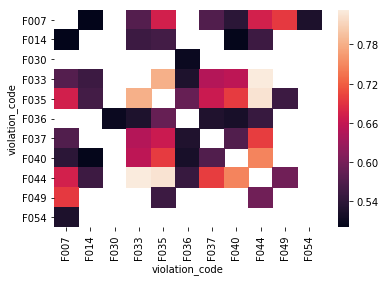

In [88]:
corr = vio_matrix.corr()
mask = (corr > 0.5) & (corr != 1.0)
masked = corr[mask]
masked.dropna(how='all', axis = 0, inplace=True)
masked.dropna(how='all', axis = 1, inplace=True)
sb.heatmap(masked)

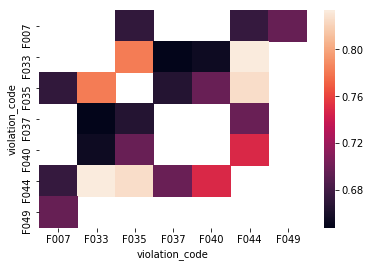

In [89]:
corr = vio_matrix.corr()
mask = (corr > 0.6) & (corr != 1.0)
masked = corr[mask]
masked.dropna(how='all', axis = 0, inplace=True)
masked.dropna(how='all', axis = 1, inplace=True)
sb.heatmap(masked)

In [90]:
inspect_vio_df.columns

Index(['serial_number', 'activity_date', 'facility_name', 'score', 'grade',
       'service_code', 'service_description', 'employee_id',
       'facility_address', 'facility_city', 'facility_id', 'facility_state',
       'facility_zip', 'owner_id', 'owner_name', 'pe_description',
       'program_element_pe', 'program_name', 'program_status', 'record_id',
       'est_type', 'seats', 'risk', 'F001', 'F002', 'F003', 'F004', 'F005',
       'F006', 'F007', 'F008', 'F009', 'F010', 'F011', 'F012', 'F013', 'F014',
       'F015', 'F016', 'F017', 'F018', 'F019', 'F021', 'F022', 'F023', 'F024',
       'F025', 'F026', 'F027', 'F028', 'F029', 'F030', 'F031', 'F032', 'F033',
       'F034', 'F035', 'F036', 'F037', 'F038', 'F039', 'F040', 'F041', 'F042',
       'F043', 'F044', 'F045', 'F046', 'F047', 'F048', 'F049', 'F050', 'F051',
       'F052', 'F053', 'F054', 'F055', 'F057', 'F058'],
      dtype='object')

In [91]:
violate_df['violation_code'].value_counts().nlargest(12).index

Index(['F044', 'F033', 'F035', 'F036', 'F040', 'F043', 'F037', 'F039', 'F030',
       'F006', 'F014', 'F007'],
      dtype='object')

## Creating a dictionary of all violations

In [92]:
violate_df[violate_df['violation_description']=='# 21a. Hot Water Available'].head(3)

,serial_number,activity_date,facility_name,violation_code,violation_description,violation_status,points,grade,facility_address,facility_city,...,owner_name,pe_description,program_element_pe,program_name,program_status,record_id,score,service_code,service_description,row_id
157,DANACKVC8,2018-03-30,SHOP RITE BROTHERS,F053,# 21a. Hot Water Available,OUT OF COMPLIANCE,2,A,1553 MANCHESTER AVE,LOS ANGELES,...,"U CAN SHOP RITE, INC.","FOOD MKT RETAIL (25-1,999 SF) LOW RISK",1610,SHOP RITE BROTHERS,ACTIVE,PR0164042,90,1,ROUTINE INSPECTION,DANACKVC8F053
241,DAXQX2YVJ,2018-03-30,SALLY'S SNACK SHOP,F053,# 21a. Hot Water Available,OUT OF COMPLIANCE,4,A,228 W 6TH ST,LOS ANGELES,...,"MARGOSSIAN, KARMEN",RESTAURANT (0-30) SEATS MODERATE RISK,1631,SALLY'S SNACK SHOP,ACTIVE,PR0037435,92,1,ROUTINE INSPECTION,DAXQX2YVJF053
305,DA3QNIBH5,2018-03-29,CUSTOM HOTEL,F053,# 21a. Hot Water Available,OUT OF COMPLIANCE,2,A,8639 LINCOLN BLVD,LOS ANGELES,...,"RAR, INC",RESTAURANT (61-150) SEATS HIGH RISK,1638,CUSTOM HOTEL-DECK 33,ACTIVE,PR0147279,93,1,ROUTINE INSPECTION,DA3QNIBH5F053


code F001 and F055 -> 01a
code F052 -> 01b
code F053 -> 21a
code F021 -> 21b

In [96]:
codes = list(violate_df['violation_code'].unique())
#print(codes)

In [97]:
vio_descs = list(violate_df['violation_description'].unique())
#print(vio_descs)

In [98]:
violation_dict = dict.fromkeys(codes)

In [99]:
for x in violation_dict:
    for desc in vio_descs:
        if x[-2:] == desc[2:4]:
            violation_dict[x] = desc
#violation_dict

In [100]:
violation_dict['F001'] = '# 01a. Demonstration of knowledge'
violation_dict['F052'] = '# 01b. Food safety certification'
violation_dict['F053'] = '# 21a. Hot Water Available'
violation_dict['F054'] = '# 52. Multiple Major Critical Violations / Increased Risk to Public Health'
violation_dict['F055'] = '# 01a. Demonstration of knowledge'
violation_dict['F057'] = '# 18. Compliance with variance, specialized process, & HACCP Plan'
violation_dict['F058'] = '# 19. Consumer advisory provided for raw or undercooked foods'

In [101]:
violation_dict

{'F030': '# 30. Food properly stored; food storage containers identified',
 'F027': '# 27. Food separated and protected',
 'F035': '# 35. Equipment/Utensils - approved; installed; clean; good repair, capacity',
 'F033': '# 33. Nonfood-contact surfaces clean and in good repair',
 'F029': '# 29. Toxic substances properly identified, stored, used',
 'F044': '# 44. Floors, walls and ceilings: properly built, maintained in good repair and clean',
 'F006': '# 06. Adequate handwashing facilities supplied & accessible',
 'F039': '# 39. Wiping cloths: properly used and stored',
 'F037': '# 37. Adequate ventilation and lighting; designated areas, use',
 'F032': '# 32. Food properly labeled & honestly presented',
 'F034': '# 34. Warewashing facilities: Adequate, maintained, properly use, test strips available',
 'F014': '# 14. Food contact surfaces: clean and sanitized',
 'F043': '# 43. Premises; personal/cleaning items; vermin-proofing',
 'F042': '# 42. Toilet facilities: properly constructed, s

#### Geographical groupings

In [102]:
inspect_df['facility_zip'].head()

0    90065
1    90045
2    90028
3    90064
4    90049
Name: facility_zip, dtype: object

In [103]:
inspect_vio_df.loc[1]

serial_number                                      DAQOKRFZB
activity_date                            2017-12-29 00:00:00
facility_name                                       REILLY'S
score                                                     92
grade                                                      A
service_code                                               1
service_description                       ROUTINE INSPECTION
employee_id                                        EE0000633
facility_address                         100 WORLD WAY # 120
facility_city                                    LOS ANGELES
facility_id                                        FA0244690
facility_state                                            CA
facility_zip                                           90045
owner_id                                           OW0208441
owner_name                         AREAS SKYVIEW LAX JV, LLC
pe_description         RESTAURANT (0-30) SEATS MODERATE RISK
program_element_pe      

In [104]:
def clean_zip(x):
    return x[:5]
inspect_vio_df['facility_zip'] = inspect_vio_df['facility_zip'].apply(clean_zip)

In [105]:
geo_group = inspect_vio_df.groupby('facility_zip')
geo_agg = geo_group.agg({'score': np.mean,
                       'facility_id': pd.Series.nunique,
                        })
geo_agg.rename(columns = {'score':'average_score','facility_id':'total_facilities'}, inplace = True)
geo_agg.reset_index(inplace=True)

##### Create Zip code list

In [152]:
# remove ZIP codes not in our dataset
geozips = []
for i in range(len(tmp['features'])):
    if tmp['features'][i]['properties']['name'] in list(geo_agg['facility_zip'].unique()):
        geozips.append(tmp['features'][i])

# creating new JSON object
new_json = dict.fromkeys(['type','features'])
new_json['type'] = 'FeatureCollection'
new_json['features'] = geozips

# save JSON object as updated-file
open("updated-file.json", "w").write(
    json.dumps(new_json, sort_keys=True, indent=4, separators=(',', ': '))
)

1160874

In [153]:
x = 'average_score'
print((' ').join(x.split('_')).title())

Average Score


In [211]:
CreateMap(geo_agg, 'facility_zip', 'average_score', 'Average score of facilities','Geo_')

In [213]:
CreateMap(geo_agg, 'facility_zip', 'total_facilities','Geo_')

In [158]:
fac_grouped = inspect_vio_df.groupby(['facility_zip','facility_id'])
fac_agg = fac_grouped.agg({'F044': np.mean,
                        'F033': np.mean,
                        'F035': np.mean,
                        'F036': np.mean,
                        'F040': np.mean,
                        'F043': np.mean,
                        'F037': np.mean,
                        'F039': np.mean,
                        'F030': np.mean,
                        'F006': np.mean,
                        'F014': np.mean,
                        'F007': np.mean})

In [159]:
fac_agg.head()

F044  F033  F035  F036  F040  F043  F037  F039  \
facility_zip facility_id                                                   
90001        FA0002183     6.0   3.0   4.0   1.0   1.0   3.0   5.0   0.0   
             FA0002627     1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
             FA0004443     1.0   1.0   1.0   0.0   0.0   1.0   0.0   0.0   
             FA0004465     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
             FA0004529     3.0   1.0   0.0   0.0   0.0   2.0   0.0   0.0   

                          F030  F006  F014  F007  
facility_zip facility_id                          
90001        FA0002183     2.0   1.0   0.0   2.0  
             FA0002627     0.0   0.0   0.0   0.0  
             FA0004443     0.0   0.0   0.0   0.0  
             FA0004465     0.0   0.0   0.0   0.0  
             FA0004529     0.0   0.0   0.0   0.0

In [160]:
fac_agg = fac_agg.groupby(level=0).mean()
fac_agg.reset_index(inplace=True)

In [161]:
fac_agg.head()

,facility_zip,F044,F033,F035,F036,F040,F043,F037,F039,F030,F006,F014,F007
0,90001,1.717391,1.257246,1.184783,0.655797,0.637681,1.054348,0.782609,0.398551,0.492754,1.090580,0.387681,0.554348
1,90002,1.724638,1.318841,0.753623,0.434783,0.492754,0.971014,0.536232,0.318841,0.434783,0.942029,0.188406,0.376812
2,90003,1.728261,1.695652,1.282609,0.666667,0.670290,1.387681,0.630435,0.369565,0.663043,1.112319,0.380435,0.684783
3,90004,2.729242,2.649819,1.888087,1.595668,1.169675,1.472924,0.794224,0.631769,1.000000,0.953069,0.985560,0.541516
4,90005,2.940397,2.986755,2.125828,1.635762,1.745033,2.099338,1.463576,2.105960,1.480132,1.122517,1.354305,0.880795


In [202]:
#def clean_zip(x):
#    return x[:5]
#inspect_vio_df['facility_zip'] = inspect_vio_df['facility_zip'].apply(clean_zip)
fac_group = inspect_vio_df.groupby(['facility_zip'])
fac_count = fac_group.agg({
    'facility_id': 'count'
})
# total number of restaurants per zip code
fac_count.head()

,facility_id
facility_zip,
90001,1023
90002,228
90003,963
90004,1263
90005,1468


#### Compare all together

In [163]:
def count_distribution(df,location,subgroup):
    group_counts = pd.DataFrame(df.groupby([location,subgroup]).size().unstack(1))
    group_counts.reset_index(inplace = True)
    return group_counts

def subgroup_distribution(df,location,subgroup):
    group = df.groupby([location,subgroup]).size()
    group_pcts = group.groupby(level=0).apply(lambda x: 100 * x/float(x.sum()))
    group_pcts = pd.DataFrame(group_pcts.unstack(1))
    group_pcts.reset_index(inplace=True)
    return group_pcts

In [164]:
seats_counts = count_distribution(inspect_vio_df, 'facility_zip', 'seats')
est_type_counts = count_distribution(inspect_vio_df, 'facility_zip', 'est_type')
risk_counts = count_distribution(inspect_vio_df, 'facility_zip', 'risk')

In [165]:
seats_dist = subgroup_distribution(inspect_vio_df, 'facility_zip', 'seats')
est_type_dist = subgroup_distribution(inspect_vio_df, 'facility_zip', 'est_type')
risk_dist = subgroup_distribution(inspect_vio_df, 'facility_zip', 'risk')

In [166]:
seats_dist.head()

seats,facility_zip,0-30,151 +,"2,000+ SF","25-1,999 SF",31-60,61-150
0,90001,45.259042,2.346041,8.308895,30.009775,12.805474,1.270772
1,90002,32.894737,2.631579,14.473684,41.228070,3.947368,4.824561
2,90003,46.936656,NaN,5.815161,38.733126,5.399792,3.115265
3,90004,36.737926,1.979414,6.571655,11.955661,24.386382,18.368963
4,90005,27.384196,5.858311,4.019074,12.602180,31.471390,18.664850


In [214]:
CreateMap(seats_counts, 'facility_zip', '0-30', 'Occupancy Facility Total Count','SeatsCount_')
CreateMap(seats_counts, 'facility_zip', '2,000+ SF', 'Occupancy Facility Total Count','SeatsCount_')

CreateMap(seats_dist, 'facility_zip', '0-30', 'Occupancy Concentration','Seats_dist_')
CreateMap(seats_dist, 'facility_zip', '2,000+ SF', 'Occupancy Concentration','Seats_dist_')

CreateMap(seats_counts, 'facility_zip', '0-30', 'Occupancy Count','Occupancy_')
CreateMap(seats_counts, 'facility_zip', '31-60', 'Occupancy Count','Occupancy_')
CreateMap(seats_counts, 'facility_zip', '61-150', 'Occupancy Count','Occupancy_')

In [168]:
est_type_dist.head()

est_type,facility_zip,FOOD MKT RETAIL,RESTAURANT
0,90001,38.318671,61.681329
1,90002,55.701754,44.298246
2,90003,44.548287,55.451713
3,90004,18.527316,81.472684
4,90005,16.621253,83.378747


In [169]:
CreateMap(est_type_counts, 'facility_zip', 'FOOD MKT RETAIL', ' Total Count','Total_')
CreateMap(est_type_counts, 'facility_zip', 'RESTAURANT', ' Total Count','Total_')

In [170]:
risk_dist.head()

risk,facility_zip,HIGH RISK,LOW RISK,MODERATE RISK
0,90001,60.410557,19.550342,20.039101
1,90002,41.228070,28.947368,29.824561
2,90003,49.428868,24.195223,26.375909
3,90004,69.358670,12.430721,18.210610
4,90005,72.207084,11.989101,15.803815


In [215]:
CreateMap(risk_counts, 'facility_zip', 'LOW RISK', ' "Low Risk" Facilities Total Count','Total_')
CreateMap(risk_counts, 'facility_zip', 'HIGH RISK', ' "High Risk" Facilities Total Count','Total_')

In [172]:
est_type_counts.head()

est_type,facility_zip,FOOD MKT RETAIL,RESTAURANT
0,90001,392.0,631.0
1,90002,127.0,101.0
2,90003,429.0,534.0
3,90004,234.0,1029.0
4,90005,244.0,1224.0


In [216]:
CreateMap(fac_agg, 'facility_zip', 'F044', 'Average Violation of Floor, Walls, and Ceiling Maintenance and Condition','Avg_Violation_')
CreateMap(fac_agg, 'facility_zip', 'F033', 'Average Violation of Nonfood Equipment Cleanliness and Maintenance','Avg_Violation_')
CreateMap(fac_agg, 'facility_zip', 'F035', 'Average Violation of Equiptment/Utensils Cleanliness and Maintenance','Avg_Violation_')
CreateMap(fac_agg, 'facility_zip', 'F036', 'Average Violation of Equiptment/Utensils/Linens Storage and Use','Avg_Violation_')
CreateMap(fac_agg, 'facility_zip', 'F040', 'Average Violation of Plumbing','Avg_Violation_')
CreateMap(fac_agg, 'facility_zip', 'F014', 'Average Violation of Surface Cleaning and Sanitization','Avg_Violation_')

In [174]:
violation_dict['F014']

'# 14. Food contact surfaces: clean and sanitized'

In [175]:
fac_agg.head()

,facility_zip,F044,F033,F035,F036,F040,F043,F037,F039,F030,F006,F014,F007
0,90001,1.717391,1.257246,1.184783,0.655797,0.637681,1.054348,0.782609,0.398551,0.492754,1.090580,0.387681,0.554348
1,90002,1.724638,1.318841,0.753623,0.434783,0.492754,0.971014,0.536232,0.318841,0.434783,0.942029,0.188406,0.376812
2,90003,1.728261,1.695652,1.282609,0.666667,0.670290,1.387681,0.630435,0.369565,0.663043,1.112319,0.380435,0.684783
3,90004,2.729242,2.649819,1.888087,1.595668,1.169675,1.472924,0.794224,0.631769,1.000000,0.953069,0.985560,0.541516
4,90005,2.940397,2.986755,2.125828,1.635762,1.745033,2.099338,1.463576,2.105960,1.480132,1.122517,1.354305,0.880795


In [176]:
fac_agg_avg= pd.DataFrame([fac_agg.iloc[:,0] , fac_agg.iloc[:, 1:-1].mean(axis=1) ] )
fac_agg_avg = fac_agg_avg.T
fac_agg_avg.rename(columns={'RegionName':'facility_zip','Unnamed 0':'Average Violation'}, inplace=True)
fac_agg_avg.head()

,facility_zip,Average Violation
0,90001,0.878129
1,90002,0.737813
2,90003,0.962451
3,90004,1.44273
4,90005,1.91451


### Comparing All

In [177]:
df_18= pd.DataFrame([Df_2018.iloc[:,0] , Df_2018.iloc[:, 1:6].mean(axis=1) ] )
df_18 = df_18.T
df_18.rename(columns={'RegionName':'facility_zip','Unnamed 0':'2018_Home_Ave'}, inplace=True)
df_18.head()

,facility_zip,2018_Home_Ave
115,90001,0.355523
133,90002,0.372818
54,90003,0.387792
11,90004,1.73046
211,90005,1.32902


In [178]:
df_17= pd.DataFrame([Df_2017.iloc[:,0] , Df_2017.iloc[:, 1:6].mean(axis=1) ] )
df_17 = df_17.T
df_17.rename(columns={'RegionName':'facility_zip','Unnamed 0':'2017_Home_Ave'}, inplace=True)
df_17.head()

,facility_zip,2017_Home_Ave
115,90001,0.32734
133,90002,0.329627
54,90003,0.351425
11,90004,1.58983
211,90005,1.17708


In [179]:
df_16= pd.DataFrame([Df_2016.iloc[:,0] , Df_2016.iloc[:, 1:6].mean(axis=1) ] )
df_16 = df_16.T
df_16.rename(columns={'RegionName':'facility_zip','Unnamed 0':'2016_Home_Ave'}, inplace=True)
df_16.head()

,facility_zip,2016_Home_Ave
115,90001,0.290602
133,90002,0.299723
54,90003,0.311745
11,90004,1.47897
211,90005,1.15032


In [180]:
df_15= pd.DataFrame([Df_2015.iloc[:,0] , Df_2015.iloc[:, 1:6].mean(axis=1) ] )
df_15 = df_15.T
df_15.rename(columns={'RegionName':'facility_zip','Unnamed 0':'2015_Home_Ave'}, inplace=True)
df_15.head()

,facility_zip,2015_Home_Ave
115,90001,0.256446
133,90002,0.268937
54,90003,0.278083
11,90004,1.35366
211,90005,1.07923


In [181]:
#total_seats = pd.DataFrame([seats_counts.iloc[:,1:7].sum(axis=1) ] )
total_seats= pd.DataFrame([seats_counts.iloc[:,0] ,seats_counts.iloc[:,1:7].sum(axis=1)] )
total_seats = total_seats.T
total_seats.rename(columns={'RegionName':'facility_zip','Unnamed 0':'Total Seats'}, inplace=True)
total_seats.head()

,facility_zip,Total Seats
0,90001,1023
1,90002,228
2,90003,963
3,90004,1263
4,90005,1468


In [182]:
## clean zip code for violation counting
def clean_zip(x):
    return x[:5]
violate_df2 = violate_df.copy()
violate_df2['facility_zip'] = violate_df2['facility_zip'].apply(clean_zip)
#violate_df2.head() 

violate_df2 = violate_df2.groupby(['facility_zip'])
violate_df2 = violate_df2.agg({
    'violation_code': 'count'
})
violate_df2.head()

#violate_df3 = violate_df2['violation_code'].unstack(0).T
#violate_df3.head()
#violate_df2.rename(columns={'facility_zip':'facility_zip','violation_code' : 'total_vio'})
violate_df2.reset_index(inplace = True)
violate_df2.rename(columns={'facility_zip':'facility_zip','violation_code' : 'total_vio'},inplace=True)
violate_df2.head()  

,facility_zip,total_vio
0,90001,4328
1,90002,859
2,90003,4737
3,90004,6295
4,90005,9197


In [255]:
from functools import reduce
#del df_merged
data_frames = [df_15,df_16,df_17,df_18]
#data_frames = [df_15,df_16]
Avg_Price = reduce(lambda  left,right: pd.merge(left,right,on=['facility_zip'],
                                            how='outer'), data_frames).fillna(0)
Avg_Price= pd.DataFrame([Avg_Price.iloc[:,0] , Avg_Price.iloc[:, 1:-1].mean(axis=1) ] )
Avg_Price = Avg_Price.T 
Avg_Price.rename(columns={'facility_zip':'facility_zip','Unnamed 0' : 'Avg_Price'},inplace=True)
Avg_Price.head()


#data_frames = [fac_agg_avg,violate_df2,total_seats,geo_agg,df_15,df_16,df_17,df_18]
data_frames = [fac_count,risk_dist,fac_agg_avg,violate_df2,total_seats,geo_agg,Avg_Price]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['facility_zip'],
                                            how='outer'), data_frames).fillna(0)
df_merged.rename(columns={"facility_id": "total_restaurants" }, inplace = True)
df_merged.rename(columns={"total_facilities": "total faci with vio" }, inplace = True)

df_merged.head()

,index,facility_zip,total facilities,HIGH RISK,LOW RISK,MODERATE RISK,Average Violation,total_vio,Total Seats,average_score,total faci with vio,Avg_Price
0,0.0,90001,1023.0,60.410557,19.550342,20.039101,0.878129,4328.0,1023.0,93.987292,276.0,0.291463
1,1.0,90002,228.0,41.228070,28.947368,29.824561,0.737813,859.0,228.0,94.570175,69.0,0.299429
2,2.0,90003,963.0,49.428868,24.195223,26.375909,0.962451,4737.0,963.0,92.843198,276.0,0.313751
3,3.0,90004,1263.0,69.358670,12.430721,18.210610,1.442731,6295.0,1263.0,92.673001,277.0,1.474152
4,4.0,90005,1468.0,72.207084,11.989101,15.803815,1.914509,9197.0,1468.0,91.307221,302.0,1.135544


In [256]:
df_merged.shape

(368, 12)

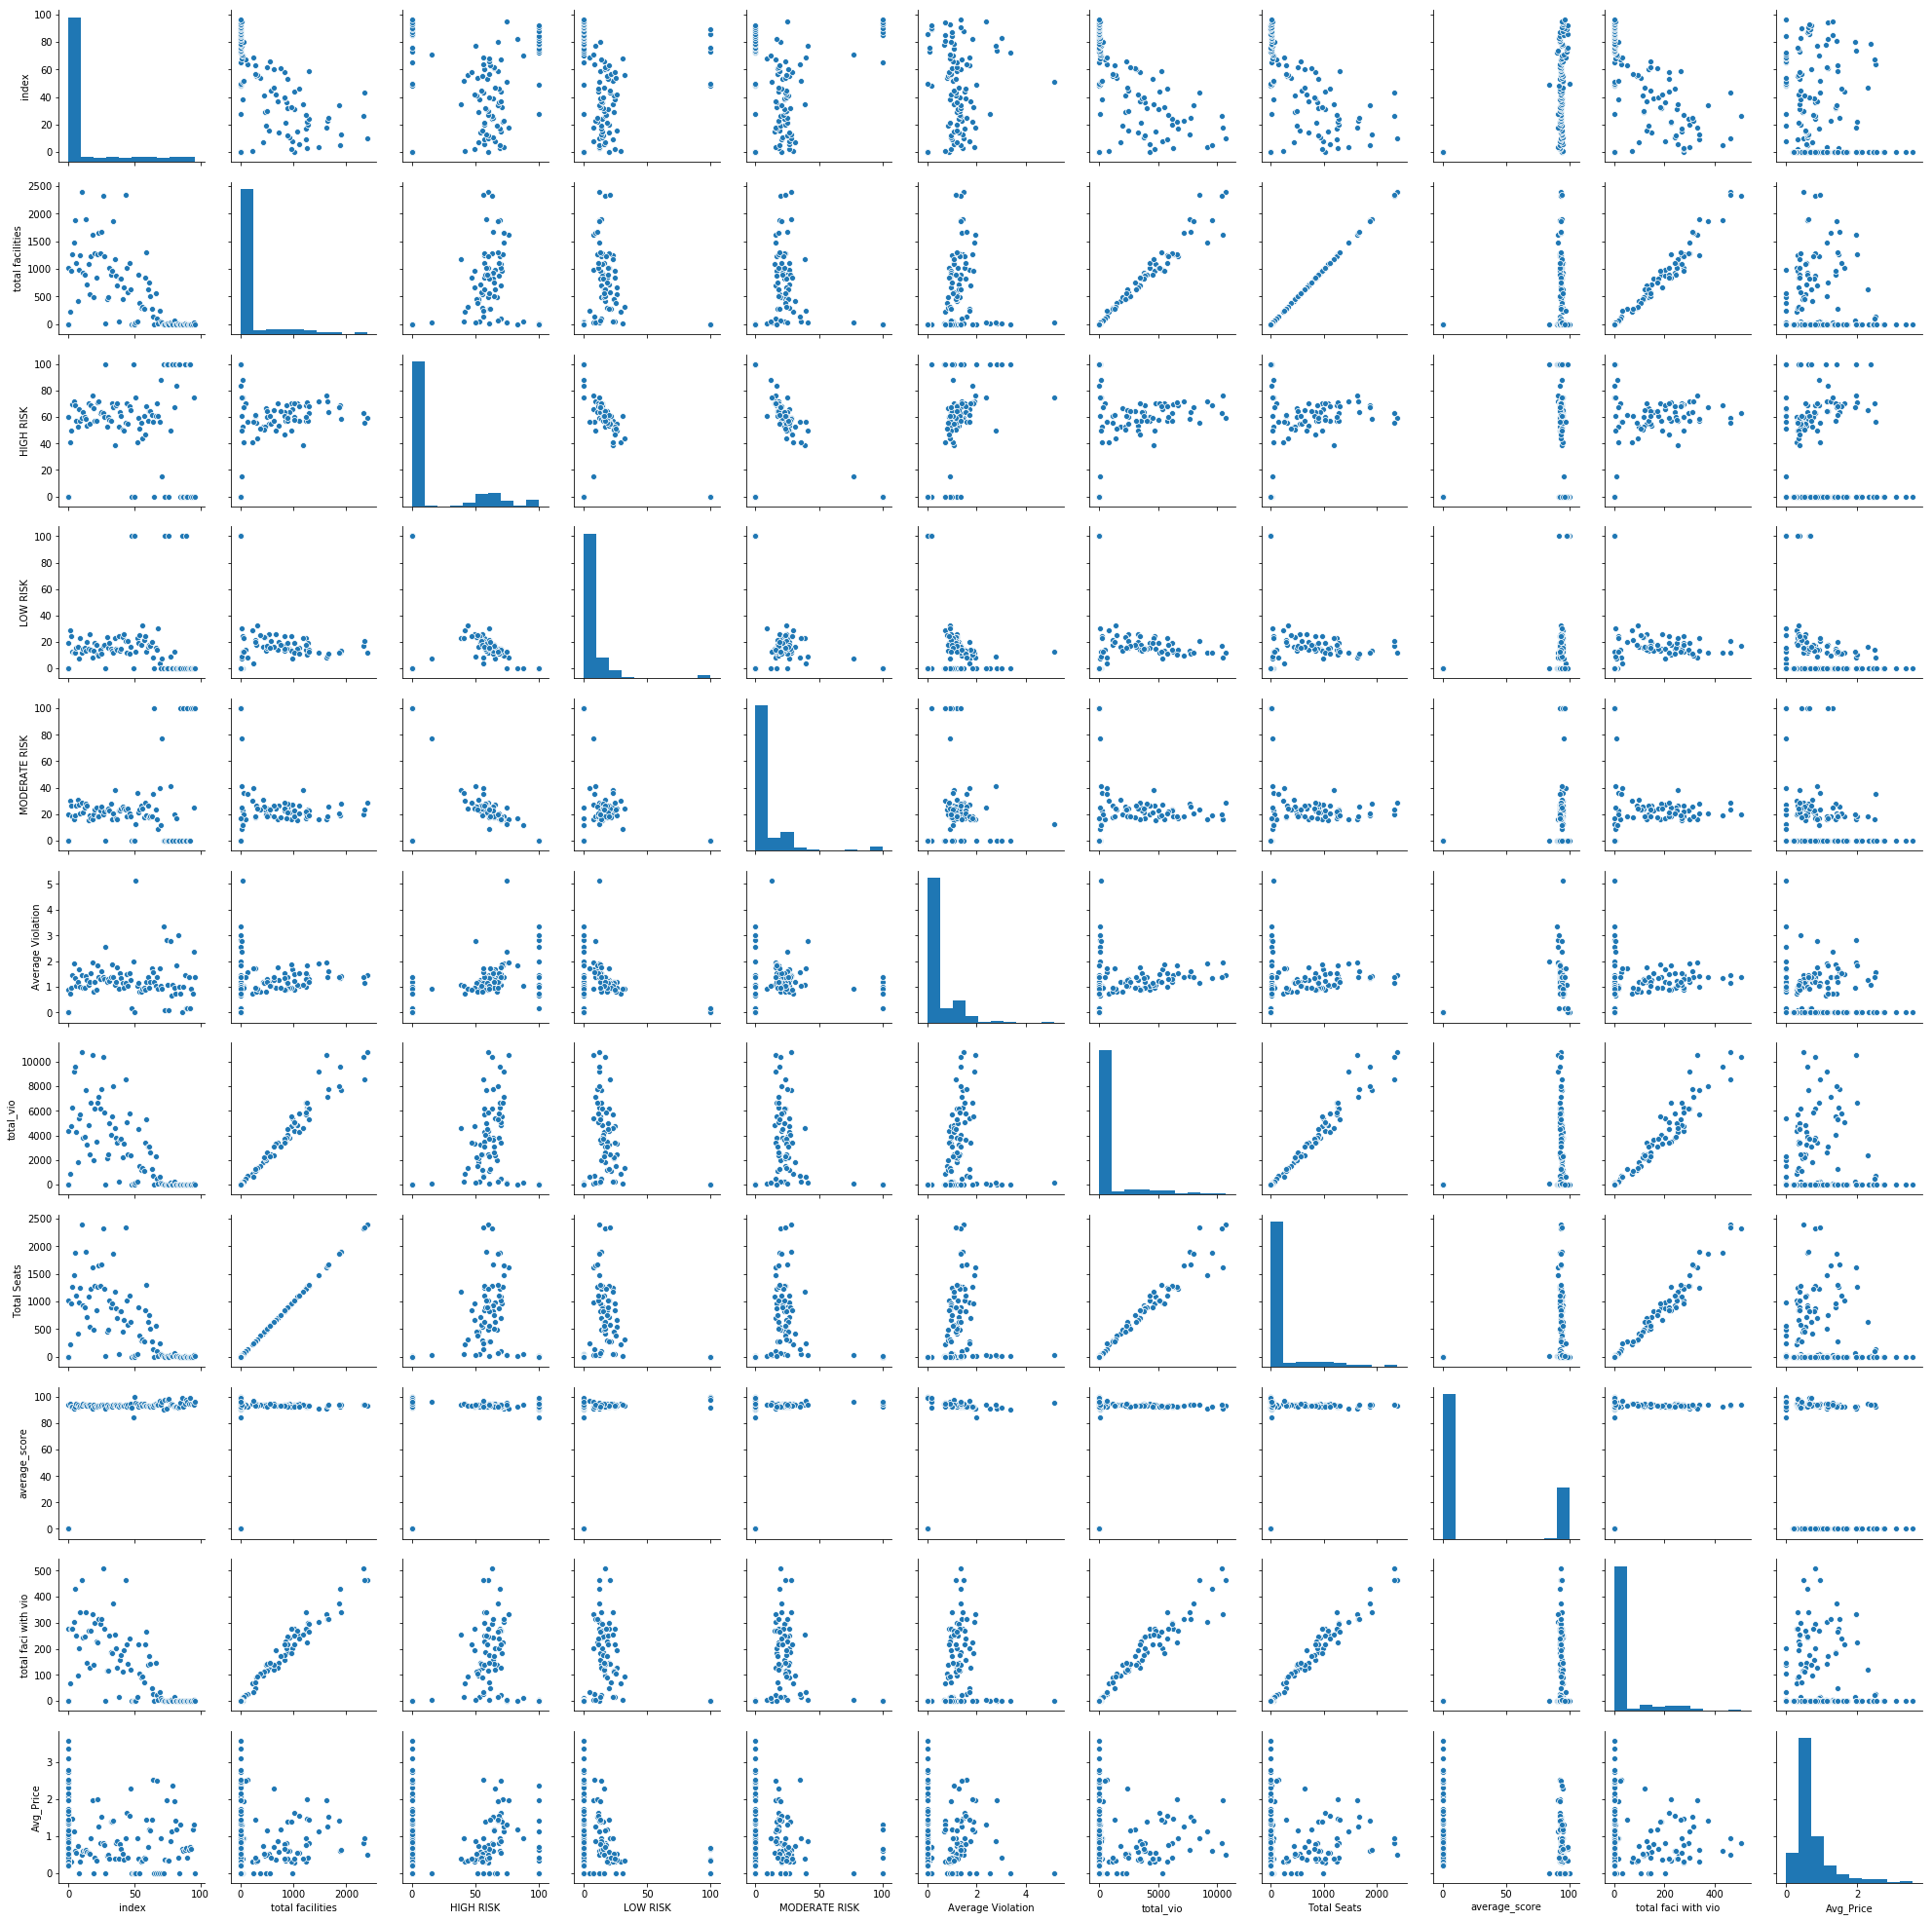

In [257]:
# library & dataset
import matplotlib.pyplot as plt
import seaborn as sns
#df = sns.load_dataset('iris') 

df = df_merged.drop(columns=['facility_zip'])
# with regression


sns.pairplot(df,kind="scatter")
#sns.pairplot(df, kind="reg")
plt.show()


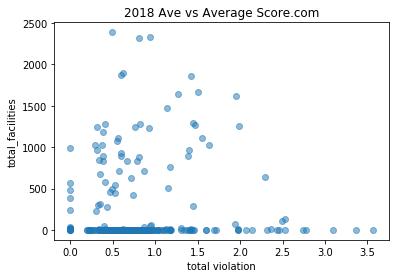

In [187]:
#df1= pd.DataFrame(data=df.iloc[:,1:3] )
#plt.matshow(df1.corr())
#plt.show()

#plt.figure(figsize=(20,10))
#sb.heatmap(df1.corr())

plt.scatter(df_merged.iloc[:,-1], df_merged.iloc[:,1],alpha=0.5)
plt.title('2018 Ave vs Average Score.com')
plt.xlabel('total violation')
plt.ylabel('total_facilities')
#plt.xlabel('average_score')
#plt.ylabel('2018 Ave(Million dollars)')
plt.show()

In [217]:
CreateMap(Avg_Price, 'facility_zip', 'Avg_Price', 'Average Price among all types of properties','AveragePrice_')

In [197]:
Avg_Price.head()

,facility_zip,Avg_Price
0,90001,0.291463
1,90002,0.299429
2,90003,0.313751
3,90004,1.47415
4,90005,1.13554


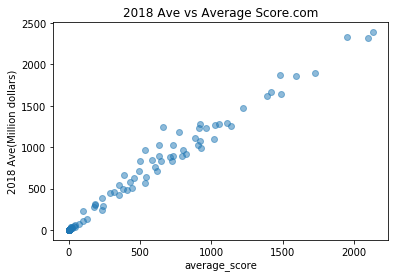

In [206]:
#df1= pd.DataFrame(data=df.iloc[:,1:3] )
#plt.matshow(df1.corr())
#plt.show()

#plt.figure(figsize=(20,10))
#sb.heatmap(df1.corr())

plt.scatter(df.iloc[:,2], df.iloc[:,3],alpha=0.5)
plt.title('2018 Ave vs Average Score.com')
plt.xlabel('average_score')
plt.ylabel('2018 Ave(Million dollars)')
plt.show()

In [218]:
fac_count.reset_index(inplace = True)
fac_count.rename(columns={'facility_zip':'facility_zip','facility_id' : 'total facilities'},inplace=True)
fac_count.head()   
CreateMap(fac_count, 'facility_zip', 'total facilities', 'Total restaurants per zip code','Total facilities_')

In [166]:
geo_agg.head()

,facility_zip,average_score,total_facilities
0,90001,93.987292,276
1,90002,94.570175,69
2,90003,92.843198,276
3,90004,92.673001,277
4,90005,91.307221,302


In [185]:
seats_counts.columns[1:6]

seats_counts.head()

seats,facility_zip,0-30,151 +,"2,000+ SF","25-1,999 SF",31-60,61-150
0,90001,463.0,24.0,85.0,307.0,131.0,13.0
1,90002,75.0,6.0,33.0,94.0,9.0,11.0
2,90003,452.0,NaN,56.0,373.0,52.0,30.0
3,90004,464.0,25.0,83.0,151.0,308.0,232.0
4,90005,402.0,86.0,59.0,185.0,462.0,274.0


## Linear Regression

In [261]:
df_merged.dtypes

index                  float64
facility_zip            object
total facilities       float64
HIGH RISK              float64
LOW RISK               float64
MODERATE RISK          float64
Average Violation      float64
total_vio              float64
Total Seats            float64
average_score          float64
total faci with vio    float64
Avg_Price              float64
dtype: object

Coefficients: 
 [[-0.0032043]]
Mean squared error: 0.34
R2-score: 0.01


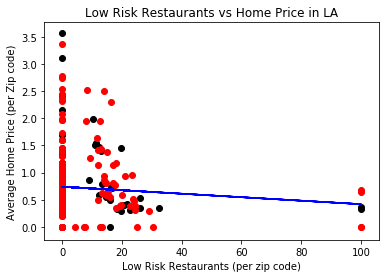

In [262]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

diabetes_X = pd.DataFrame(df_merged.iloc[:,[4]])
diabetes_y = pd.DataFrame(df_merged.iloc[:,[-1]])

X_train, X_test, y_train, y_test = train_test_split(
    diabetes_X,diabetes_y, test_size=0.25, random_state=42) 

# Create linear regression object
lm =LinearRegression()

# Train the model using the training sets
lm.fit(X_train, y_train)

# Make predictions using the testing set
prediction = lm.predict(X_test)


# The coefficients
print('Coefficients: \n', lm.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, prediction))
# Explained variance score: 1 is perfect prediction
print('R2-score: %.2f' % r2_score(y_test, prediction))

# Plot outputs
plt.scatter(X_test, y_test,  color='black')
#plt.plot(X_test, y_test, color='blue', linewidth=3)


plt.scatter(X_train, y_train, color = 'red')
plt.plot(X_test, prediction, color = 'blue')
plt.title('Low Risk Restaurants vs Home Price in LA')
plt.xlabel('Low Risk Restaurants (per zip code)')
plt.ylabel('Average Home Price (per Zip code)')
plt.show() 

In [265]:
import numpy as np
from pandas import DataFrame as df
from scipy.stats import trim_mean, kurtosis
from scipy.stats.mstats import mode, gmean, hmean
df_merged.describe()

,index,total facilities,HIGH RISK,LOW RISK,MODERATE RISK,Average Violation,total_vio,Total Seats,average_score,total faci with vio,Avg_Price
count,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000
mean,12.652174,159.978261,15.233565,4.719983,6.405147,0.334409,741.260870,159.978261,24.720458,35.578804,0.732113
std,25.605872,418.723022,29.248437,14.114291,16.437775,0.668304,1962.181082,418.723022,41.388604,90.786057,0.536454
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.441465
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.579190
75%,4.250000,1.250000,0.000000,0.000000,0.000000,0.181818,2.500000,1.250000,91.291091,1.000000,0.822766
max,96.000000,2389.000000,100.000000,100.000000,100.000000,5.136364,10741.000000,2389.000000,100.000000,507.000000,3.568451


In [266]:
Df_2015.describe()

,1Bed,2Bed,3Bed,4Bed,5Bed or More,single family house
count,196.000000,341.000000,347.000000,330.000000,291.000000,349.000000
mean,0.357129,0.496467,0.678598,0.857082,1.162139,0.756962
std,0.222596,0.276477,0.429627,0.622579,0.980056,0.566038
min,0.123342,0.123808,0.154400,0.173875,0.231283,0.159483
25%,0.233362,0.338567,0.433225,0.481415,0.573371,0.445767
50%,0.294496,0.410275,0.553933,0.658929,0.794200,0.586025
75%,0.417692,0.556342,0.745762,0.914404,1.311100,0.836533
max,1.782908,2.184708,2.887417,4.087250,6.643850,4.365642


In [275]:
Df_2018.describe()

,1Bed,2Bed,3Bed,4Bed,5Bed or More,single family house
count,196.000000,341.000000,347.000000,330.000000,291.000000,349.000000
mean,0.457447,0.623080,0.834936,1.041903,1.399759,0.928720
std,0.270307,0.333606,0.520322,0.755540,1.191462,0.688429
min,0.180308,0.185050,0.230567,0.251425,0.312517,0.235633
25%,0.308246,0.428775,0.541817,0.602123,0.698771,0.561592
50%,0.382792,0.520325,0.666483,0.772429,0.939342,0.699600
75%,0.527394,0.683533,0.907863,1.122381,1.567721,0.975500
max,2.187317,2.689483,3.668275,5.568408,8.435283,5.854908


In [277]:
#Raising = np.divide(Df_2018 , Df_2015) 
#Raising = Df_2018.reset_index(drop=True) / Df_2015.reset_index(drop=True) 
#Raising.index = Df_2018.index 
#Raising.head()

,RegionName,1Bed,2Bed,3Bed,4Bed,5Bed or More,single family house
115,90001,0.284758,0.340133,0.376883,0.420317,NaN,0.359175
133,90002,0.304008,0.340417,0.371700,0.397767,0.450200,0.361817
54,90003,0.320417,0.348775,0.378292,0.411250,0.480225,0.362717
11,90004,0.666875,0.872742,1.408492,2.215858,3.488333,1.578008
211,90005,NaN,0.616283,0.814017,1.569850,2.315925,1.606383


## Working Zone

In [595]:
#Df_2018.rename(columns={'RegionName':'facility_zip'}, inplace=True)

In [761]:
Df_2015.head()
#Df_2016.shape

,RegionName,1Bed,2Bed,3Bed,4Bed,5Bed or More,single family house
49,90002,0.206733,0.244025,0.269650,0.297692,0.326583,0.263150
20,90003,0.225308,0.249800,0.277417,0.298992,0.338900,0.263025
4,90004,0.498883,0.660233,0.980083,1.770367,2.858717,1.275550
73,90005,0.000000,0.502333,0.710808,1.274800,1.828983,1.301558
14,90006,0.400100,0.480258,0.546367,0.639358,0.657867,0.553183


In [666]:
#geo_agg.head()
#del ZipCode
ZipCode = geo_agg 
ZipCode.rename(columns={'facility_zip':'RegionName'}, inplace=True)
#ZipCode = pd.DataFrame(data = geo_agg.loc[: , 'facility_zip'])
#ZipCode.columns = ['RegionName']
#ZipCode = ZipCode.sort_values(by=['RegionName'])
ZipCode.head()

,RegionName,average_score,total_facilities
0,90001,93.987292,276
1,90002,94.570175,69
2,90003,92.843198,276
3,90004,92.673001,277
4,90005,91.307221,302


In [684]:
Df_2015.head(5)

,RegionName,1Bed,2Bed,3Bed,4Bed,5Bed or More,single family house
49,90002,2.067333,2.440250,2.696500,2.976917,3.265833,2.631500
20,90003,2.253083,2.498000,2.774167,2.989917,3.389000,2.630250
4,90004,4.988833,6.602333,9.800833,17.703667,28.587167,12.755500
73,90005,0.000000,5.023333,7.108083,12.748000,18.289833,13.015583
14,90006,4.001000,4.802583,5.463667,6.393583,6.578667,5.531833


In [579]:
ZipCode.dtypes

RegionName           object
average_score       float64
total_facilities      int64
dtype: object

In [583]:
#Df_2015.astype({'RegionName': 'object'}).dtypes
Df_2015['RegionName'] = Df_2015['RegionName'].astype(object) 
Df_2015.dtypes
#Df_2015
#Df_2015.head()
#Df_2015.shape

RegionName              object
1Bed                   float64
2Bed                   float64
3Bed                   float64
4Bed                   float64
5Bed or More           float64
single family house    float64
dtype: object

In [560]:
ZipCode['total_facilities'] = ZipCode['total_facilities'].astype(float)
ZipCode.dtypes

RegionName           object
average_score       float64
total_facilities    float64
dtype: object

In [573]:
#geo_agg.head()

ZipCode =pd.DataFrame(data = geo_agg.loc[: , 'facility_zip'])
ZipCode.columns = ['RegionName']
ZipCode.head()
ZipCode.shape
#ZipCode

(97, 1)

In [567]:
ZipCode.dtypes

RegionName    object
dtype: object

In [596]:
Df_2018.apply(str)

facility_zip           49    90002.0\n20    90003.0\n4     90004.0\n7...
1Bed                   49    0.304008\n20    0.320417\n4     0.666875...
2Bed                   49    0.340417\n20    0.348775\n4     0.872742...
3Bed                   49    0.371700\n20    0.378292\n4     1.408492...
4Bed                   49    0.397767\n20    0.411250\n4     2.215858...
5Bed or More           49    0.450200\n20    0.480225\n4     3.488333...
single family house    49    0.361817\n20    0.362717\n4     1.578008...
dtype: object

In [659]:
Df_2018.dtypes
#Df_2018.head(30)

facility_zip             int64
1Bed                   float64
2Bed                   float64
3Bed                   float64
4Bed                   float64
5Bed or More           float64
single family house    float64
dtype: object

In [621]:
import geocoder
g = geocoder.arcgis(Df_2018.iloc[1][0])
g.latlng

[33.96288000000004, -118.27206999999999]

In [620]:
Df_2018.iloc[1][0]

90003.0

In [622]:
len(Df_2018)

99

In [633]:
g = geocoder.arcgis(Df_2018.iloc[0][0])
lon,lat = g.latlng 
lon,lat
type(lat)

float

In [660]:
# for speed purposes
import folium
import geocoder
  
# create empty map zoomed in on LA [34.0522, -118.2437]
map = folium.Map(location=[34.0522, -118.2437], zoom_start=12)
# I can add marker one by one on the map
#df = Df_2018.loc[:,1]
for i in range(0,len(Df_2018)):
    g = geocoder.arcgis(Df_2018.iloc[i][0])
    folium.Circle(      
      #lon,lat = g.latlng 
      location= g.latlng, #[data.iloc[i]['lon'], data.iloc[i]['lat']],
      popup=str(Df_2018.iloc[i]['1Bed']),  #Df_2018.iloc[i]['1Bed'],
      radius= Df_2018.iloc[i]['1Bed']*1000,
      color='crimson',
      fill=True,
      fill_color="#007849"
    ).add_to(map)

    
#map.save('Map Test.html')
 
display(map)

In [661]:
import folium

# table = main table/data frame we read from (pandas DataFrame)
# zips = column name where ZIP codes are (string)
# mapped_feature = column name for feature we want to visualize (string)
# add_text = any additional commentary to be added in the map legend (string)

def create_map02(table, zips, mapped_feature, add_text = '',TITLE = ''):
    # reading of the updated GeoJSON file
    la_geo = r'updated-file.json'
    # initiating a Folium map with LA's longitude and latitude
    m = folium.Map(location = [34.0522, -118.2437], zoom_start = 11)
    # creating a Choropleth map
    m.choropleth(
        geo_data = la_geo,
        fill_opacity = 0.7,
        line_opacity = 0.2,
        data = table,
        # refers to which key within the GeoJSON to map the ZIP code to
        key_on = 'feature.properties.name',
        # first element contains location information, second element contains feature of interest
        columns = [zips, mapped_feature],
        fill_color = 'RdYlGn',
        legend_name = (' ').join(mapped_feature.split('_')).title() + ' ' + add_text + ' Across LA'
    )
    folium.LayerControl().add_to(m)
    # save map with filename based on the feature of interest
    m.save(outfile = TITLE+ mapped_feature + '_map.html')

In [694]:
Df_2018.head(3)
df = Df_2018[['RegionName', '3Bed']].copy() 
df.loc[0].astype(object)
df.head()
df.dtypes

RegionName      int64
3Bed          float64
dtype: object

In [686]:
create_map02(df, 'RegionName', '3Bed', 'Average Price for single family house properties','2018_')

C:\Users\mimib\AppData\Local\Continuum\anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [710]:
Df_2018['RegionName'] = Df_2018['RegionName'].astype(str).astype(object) 
create_map02(Df_2018, 'RegionName', '1Bed', 'XXXX','test_')

In [407]:
#Df_2015.astype({'RegionName': 'object'}).dtypes

RegionName              object
CountyName              object
1Bed                   float64
2Bed                   float64
3Bed                   float64
4Bed                   float64
5Bed or More           float64
single family house    float64
dtype: object

In [592]:
geo_agg.head()

,facility_zip,average_score,total_facilities
0,90001,93.987292,276
1,90002,94.570175,69
2,90003,92.843198,276
3,90004,92.673001,277
4,90005,91.307221,302


In [601]:
df = pd.DataFrame(data = geo_agg.loc[10:11,:]) 
df.head()

,facility_zip,average_score,total_facilities
10,90012,93.395563,465
11,90013,94.455628,242


In [602]:
create_map(df, 'facility_zip', 'average_score', 'Average Score of Inspection')

In [695]:
geo_agg.dtypes

RegionName           object
average_score       float64
total_facilities      int64
dtype: object

In [707]:
geo_agg['RegionName'] = geo_agg['RegionName'].astype(str).astype(object) 
geo_agg.dtypes
#geo_agg.head()

RegionName           object
average_score       float64
total_facilities      int64
dtype: object

In [708]:
create_map(geo_agg, 'RegionName', 'average_score', 'Average Score of Inspection')

In [409]:
Df_2015.head()

,RegionName,CountyName,1Bed,2Bed,3Bed,4Bed,5Bed or More,single family house
0,90046,Los Angeles County,0.444767,0.871650,1.505192,2.073117,2.536367,1.524542
1,90044,Los Angeles County,0.236108,0.282158,0.321317,0.347642,0.387608,0.300817
2,90026,Los Angeles County,0.568992,0.700708,0.770700,0.838942,0.887883,0.741025
3,90066,Los Angeles County,0.378542,0.840942,1.088708,1.307100,1.718667,1.095892
4,90004,Los Angeles County,0.498883,0.660233,0.980083,1.770367,2.858717,1.275550


In [406]:
Df_2015.dtypes

RegionName               int64
CountyName              object
1Bed                   float64
2Bed                   float64
3Bed                   float64
4Bed                   float64
5Bed or More           float64
single family house    float64
dtype: object

In [439]:
geo_agg.head()


geo_agg.shape

(97, 3)

facility_zip         object
average_score       float64
total_facilities      int64
dtype: object

In [ ]:
#pdList = [data1[:,-1],Bed2,Bed3,Bed4,Bed5,Bed6] 
#result = pd.concat(pdList, axis=1, sort=False)
#result.head(10)

### Get all zip code list

In [425]:
#geo_agg.head()
ZipCode =pd.DataFrame(data = geo_agg.loc[: , 'facility_zip'])
ZipCode.columns = ['RegionName']
ZipCode.head()

,RegionName
0,90001
1,90002
2,90003
3,90004
4,90005


### Get all zip code list

In [34]:
#geo_agg.head()

ZipCode =pd.DataFrame(data = geo_agg.loc[: , 'facility_zip'])
ZipCode.columns = ['RegionName']
ZipCode.head()

NameError: name 'geo_agg' is not defined